# Scowl Simulated Deployment

The objective of this notebook is to:
1. Define the goals of the simulation run
2. Declare the methods of running the simulation
3. Visualize the simulation parameters
4. Run the simulations
5. Process the log data
6. Visualize the results

## What is the scope of the simulation?

1. Confirm the simulation parameters
    1. `Peer` mix (generator, consumer, superpeer/storage)
    2. Supply/Demand ratio
    3. `Peer` to `Tracker` network latency
    
2. The evaluation should answer:
    1. How many peers were rebalanced (independant variable) and how fast was the tracker able to rebalance its peers (dependant variable – in Hz)?
    2. What was the limiting resource? (e.g., network, cpu, memory, etc.)
    3. At what scale of peers did the limiting factor occur?
    4. How long was the average peer "starved" for electricity?
    5. When demand exceeded supply, did a black out occur?
    6. When should the system be sharded?
    7. When the network partitioned, did peers operating in SOC mode cause a black out in their region?
    8. *Stretch Goal* How small of a partition can the grid operate under?

# Simulation "Run Sheet"

The simulation should have (2) main parts:
1. **Electrical stress test under a healthy network** – There are imbalances between supply and demand, but the network remains up. `Trackers` attempt to pair `Consumers` with `Generators` that have additional capacity, the goal is to re-build the *ephemeral distribution trees* as fast as possible, so that `Consumer` starvation is minimized.
2. **Electrical stress test under a partitioned network** – Communication between the tracker and the peers is broken. Each `Consumer` is operating as a self optimizing consumer (soc). Each `Generator` is a self-optimizing generator (sog). `Generators` can **only** warn SOCs of an impending black out by sending a `capacity_low` rpc to their partition. This is analagous to real-world electricity consumers feeling the voltage sag of a brown-out, in advance of a black out. The warned consumers respond by self-imposing a call to `DemandResponse()`, until the `Generator` unchokes them <sup>1</sup>. The key metric here is how many `capacity_low` messages are sent, and how much *deferred consumption* consumers experience (i.e., this messaged in time and kWhs).

The energy mix will be based on the current the energy mix of New York State, and renewables will experience the same fluctations. The same "day" will be simulated for both the healthy network day (scowl) and the partitioned network day (soc/sog).

***
<sup>1</sup> This behaviour mimics the TCP congestion control algorithm, with a similar expectation that backing off demand will result in data (electricity) flowing again.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Electricity Generation Mix NY State (2020)

In [2]:
g22 = pd.read_csv("data/2022_elec_gen_mix.csv")
g22.set_index("type", inplace= True)
g22['portion'] = g22.mwh / (g22.mwh.sum())
g22.sort_values('mwh', ascending=False, inplace=True)
g22['renewable'] = [False, False, True, True, True, False, True, True]
g22

,mwh,portion,renewable
type,,,
natural gas-fired,7530000,0.585810,False
nuclear,2380000,0.185156,False
hydroelectric,2234000,0.173798,True
land-based wind,383000,0.029796,True
utility-scale solar,287000,0.022328,True
petroleum-fired,40000,0.003112,False
offshore wind,0,0.000000,True
distributed solar,0,0.000000,True


In [3]:
# pd.concat([g22,pd.DataFrame(g22.sum()).T]).rename(index={0: '2022 Total'})

In [4]:
# Assigning consistent colors for graphs
import matplotlib.colors as mcolors
mcolors.TABLEAU_COLORS

colors = []
for i, v in enumerate(g22.index):
    colors.append([v, list(mcolors.TABLEAU_COLORS.items())[i][0]])
colors = pd.DataFrame(colors, columns=["type", "color"]).set_index("type")

# using either is fine
g22 = pd.concat([g22,colors], axis = 1)
color_dict = g22.color.to_dict()

***

## Electricity Generation Mix NY State (2030)

In [5]:
g30 = pd.read_csv("data/2030_elec_gen_mix.csv")
g30.set_index("type", inplace= True)
g30['portion'] = g30.mwh / (g30.mwh.sum())
g30.sort_values('mwh', ascending=False, inplace=True)
g22 = g22.reindex(g30.index.to_list()) # make g22 use same index order as g30
g30['renewable'] = g22['renewable']
g30['color'] = g22['color']
g30
# pd.concat([g30,pd.DataFrame(g30.sum()).T]).rename(index={0: '2023 Total'})

,mwh,portion,renewable,color
type,,,,
hydroelectric,3252480,0.302400,True,tab:green
nuclear,2380000,0.221281,False,tab:orange
natural gas-fired,1276889,0.118719,False,tab:blue
offshore wind,1258400,0.117000,True,tab:pink
utility-scale solar,1132560,0.105300,True,tab:purple
distributed solar,761493,0.070800,True,tab:gray
land-based wind,693733,0.064500,True,tab:red
petroleum-fired,0,0.000000,False,tab:brown


## Electricity Mix 2022 and 2030

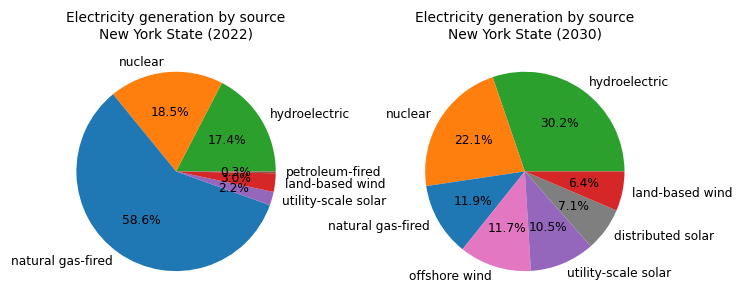

In [6]:
fig = plt.figure(figsize=(7.5,3), dpi=110)

ax1 = fig.add_subplot(121)
ax1.pie(np.round(g22[g22.portion > 0].portion*100,1), labels=g22[g22.portion > 0].index,autopct='%.1f%%', textprops={'fontsize': 8}, colors=g22[g22.portion > 0].color)
ax1.title.set_text('Electricity generation by source\nNew York State (2022)')
ax1.title.set_size(9)

ax2 = fig.add_subplot(122)
ax2.pie(np.round(g30[g30.portion > 0].portion*100,1), labels=g30[g30.portion > 0].index,autopct='%.1f%%', textprops={'fontsize': 8}, colors=g30[g30.portion > 0].color)
ax2.title.set_text('Electricity generation by source\nNew York State (2030)')
ax2.title.set_size(9)

plt.show()

In [7]:
df = pd.concat([g22.portion,g30.portion], axis=1)
df.columns = ["g22","g30"]
capacity_increase = df.g30 / df.g22
capacity_increase[~np.isfinite(capacity_increase)] = g30.portion[~np.isfinite(capacity_increase)]*100
capacity_increase

type
hydroelectric           1.739951
nuclear                 1.195103
natural gas-fired       0.202658
offshore wind          11.700001
utility-scale solar     4.716119
distributed solar       7.079997
land-based wind         2.164707
petroleum-fired         0.000000
dtype: float64

## Electricity Generation by Month

In [12]:
# for month in unique_months:
#     _df = monthly_elec.loc[month]

In [13]:
monthly_elec = pd.read_csv("data/ny_electricity_by_month.csv", skiprows=4)
monthly_elec.drop(["units","source key"], axis=1,inplace=True)
monthly_elec.set_index("description", inplace=True)
monthly_elec = monthly_elec.T
monthly_elec.drop(["New York", "New York : all fuels (utility-scale)"], axis=1,inplace=True)
monthly_elec.columns = ["hydroelectric", "other_renewables"]

month_years = [i.split("-") for i in monthly_elec.index.to_list()]
months = [i[0] for i in month_years]
years = [int(i[1]) for i in month_years]

monthly_elec.index = months
monthly_elec['year'] = (np.array(years) + 2000).astype(int)

monthly_elec.head(12).T

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
hydroelectric,2017.0,2013.0,2203.0,2043.0,2053.0,1921.0,1801.0,1698.0,1575.0,1740.0,1909.0,2110.0
other_renewables,154.0,141.0,156.0,141.0,159.0,154.0,153.0,159.0,147.0,138.0,145.0,154.0
year,2001.0,2001.0,2001.0,2001.0,2001.0,2001.0,2001.0,2001.0,2001.0,2001.0,2001.0,2001.0


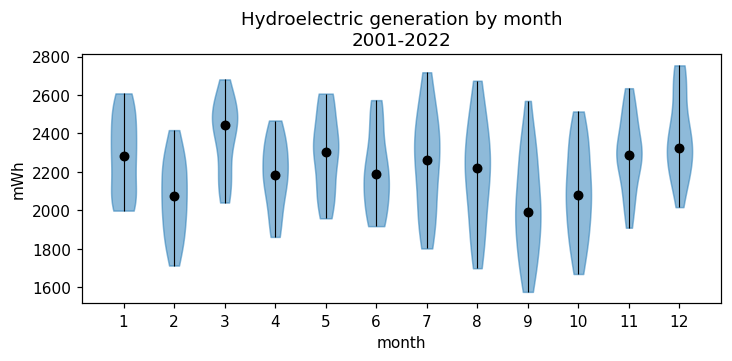

In [14]:
hydro_mwh = []
for month in monthly_elec.index.unique():
    hydro_mwh.append(monthly_elec.hydroelectric[monthly_elec.index == month].values)

hydro_mins = pd.DataFrame(hydro_mwh).T.min()
hydro_maxs = pd.DataFrame(hydro_mwh).T.max()
hydro_meds = pd.DataFrame(hydro_mwh).T.median()

fig, ax1 = plt.subplots(figsize=(7.5,3), dpi=110)

parts1 = ax1.violinplot(hydro_mwh, showmedians=False, showextrema=False)
ax1.set_title('Hydroelectric generation by month\n2001-2022')
ax1.set_xticks(np.arange(1, 12 + 1))
ax1.set_ylabel("mWh")
ax1.set_xlabel("month")

for pc in parts1['bodies']:
    pc.set_ec('tab:blue')
    pc.set_facecolor('tab:blue')
    pc.set_alpha(0.5)
    

# ax1.scatter([1]*len(months), monthly_elec.hydroelectric, marker='o', color='k', s=15, alpha=.1,zorder=3)
ax1.scatter(range(1,12+1), hydro_meds, marker='o', color='k', s=30, alpha=1,zorder=3)
ax1.vlines(range(1,12+1), hydro_mins, hydro_maxs, color='k', linestyle='-', lw=0.75)

plt.show()

In [16]:
unique_months = monthly_elec.index.unique()
unique_months

Index(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'],
      dtype='object')

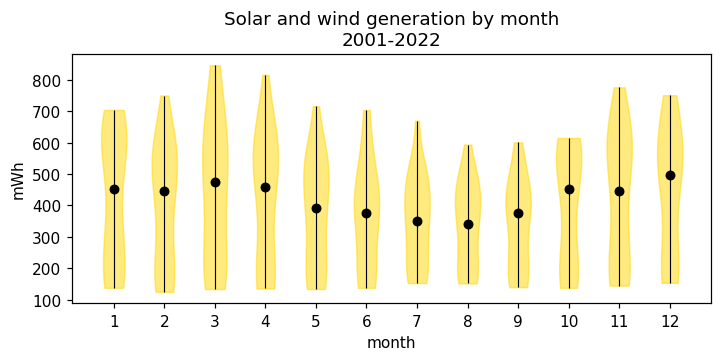

In [15]:
other_mwh = []
for month in monthly_elec.index.unique():
    other_mwh.append(monthly_elec.other_renewables[monthly_elec.index == month].values)

other_mins = pd.DataFrame(other_mwh).T.min()
other_maxs = pd.DataFrame(other_mwh).T.max()
other_meds = pd.DataFrame(other_mwh).T.median()

fig, ax1 = plt.subplots(figsize=(7.5,3), dpi=110)

parts1 = ax1.violinplot(other_mwh, showmedians=False, showextrema=False)
ax1.set_title('Solar and wind generation by month\n2001-2022')
ax1.set_xticks(np.arange(1, 12+1))
ax1.set_ylabel("mWh")
ax1.set_xlabel("month")

for pc in parts1['bodies']:
    pc.set_ec('gold')
    pc.set_facecolor('gold')
    pc.set_alpha(0.5)
    
# ax1.scatter([1]*len(months), monthly_elec.hydroelectric, marker='o', color='k', s=15, alpha=.1,zorder=3)
ax1.scatter(range(1,12+1), other_meds, marker='o', color='k', s=30, alpha=1,zorder=3)
ax1.vlines(range(1,12+1), other_mins, other_maxs, color='k', linestyle='-', lw=0.75)

plt.show()

***

Start the process of turning this data into generator state mutation scripts

In [17]:
pd.DataFrame(hydro_mwh)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2017.0,2051.0,1998.0,2043.0,2398.0,2472.0,2608.0,2293.0,2263.0,2205.0,...,2198.0,2030.0,2072.0,2318.0,2425.0,2270.0,2549.0,2544.0,2578.0,2377.0
1,2013.0,2047.0,1712.0,1833.0,2197.0,2318.0,2067.0,1915.0,2079.0,1978.0,...,1878.0,1935.0,1802.0,2171.0,2262.0,2245.0,2248.0,2372.0,2077.0,2195.0
2,2203.0,2392.0,2040.0,2133.0,2458.0,2471.0,2468.0,2484.0,2542.0,2325.0,...,2167.0,2149.0,2066.0,2326.0,2572.0,2681.0,2642.0,2521.0,2427.0,2527.0
3,2043.0,2221.0,1861.0,1890.0,2365.0,2187.0,2159.0,2259.0,2329.0,2052.0,...,1913.0,2095.0,1990.0,2350.0,2402.0,2452.0,2303.0,2467.0,2311.0,2184.0
4,2053.0,2369.0,2125.0,1958.0,2288.0,2305.0,2302.0,2363.0,2452.0,2070.0,...,1971.0,2300.0,2089.0,2366.0,2550.0,2589.0,2607.0,2582.0,2368.0,2244.0
5,1921.0,2258.0,2065.0,1969.0,2087.0,2135.0,1986.0,2174.0,2246.0,2064.0,...,1918.0,2198.0,2101.0,2265.0,2573.0,2484.0,2543.0,2425.0,2341.0,2217.0
6,1801.0,2041.0,1945.0,2022.0,2004.0,2379.0,1905.0,2302.0,2357.0,2158.0,...,2206.0,2276.0,2460.0,2252.0,2670.0,2539.0,2718.0,2546.0,2435.0,2234.0
7,1698.0,1849.0,2078.0,2020.0,1850.0,2317.0,1913.0,2197.0,2300.0,2073.0,...,2096.0,2243.0,2410.0,2210.0,2611.0,2475.0,2674.0,2497.0,2447.0,2233.0
8,1575.0,1727.0,1794.0,1918.0,1718.0,1992.0,1797.0,1988.0,2082.0,1947.0,...,1926.0,2087.0,2230.0,2017.0,2391.0,2297.0,2569.0,2373.0,2273.0,NaN
9,1740.0,1798.0,1955.0,1890.0,1888.0,2156.0,1851.0,2035.0,2160.0,2012.0,...,2071.0,2176.0,2184.0,2079.0,2385.0,2379.0,2514.0,2385.0,2374.0,NaN


In [18]:
pd.DataFrame(other_mwh)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,154.0,138.0,144.0,154.0,159.0,215.0,239.0,273.0,333.0,408.0,...,601.0,641.0,674.0,666.0,558.0,627.0,649.0,590.0,495.0,704.0
1,141.0,125.0,126.0,146.0,142.0,217.0,222.0,238.0,357.0,365.0,...,423.0,547.0,509.0,612.0,571.0,599.0,597.0,602.0,514.0,750.0
2,156.0,140.0,134.0,180.0,168.0,205.0,270.0,259.0,356.0,419.0,...,493.0,612.0,629.0,582.0,623.0,504.0,668.0,711.0,846.0,827.0
3,141.0,141.0,136.0,147.0,152.0,206.0,244.0,245.0,463.0,409.0,...,575.0,633.0,576.0,435.0,607.0,559.0,607.0,680.0,586.0,816.0
4,159.0,134.0,149.0,149.0,166.0,204.0,212.0,283.0,396.0,385.0,...,481.0,499.0,515.0,432.0,566.0,525.0,505.0,582.0,576.0,716.0
5,154.0,161.0,138.0,155.0,165.0,201.0,219.0,336.0,330.0,351.0,...,418.0,393.0,421.0,479.0,544.0,464.0,556.0,495.0,674.0,704.0
6,153.0,168.0,158.0,168.0,172.0,217.0,219.0,269.0,330.0,355.0,...,364.0,464.0,397.0,437.0,480.0,466.0,482.0,532.0,493.0,670.0
7,159.0,162.0,152.0,162.0,168.0,209.0,226.0,244.0,323.0,348.0,...,388.0,410.0,409.0,427.0,448.0,465.0,492.0,501.0,489.0,594.0
8,147.0,156.0,140.0,155.0,171.0,212.0,225.0,245.0,331.0,431.0,...,411.0,450.0,377.0,395.0,458.0,457.0,497.0,583.0,601.0,NaN
9,138.0,155.0,151.0,164.0,170.0,235.0,215.0,260.0,381.0,451.0,...,522.0,577.0,589.0,531.0,615.0,589.0,603.0,601.0,584.0,NaN


In [19]:
from scipy.stats import norm

In [20]:
monthly_elec.head(3)

,hydroelectric,other_renewables,year
Jan,2017.0,154.0,2001
Feb,2013.0,141.0,2001
Mar,2203.0,156.0,2001


In [21]:
from scipy.stats import beta

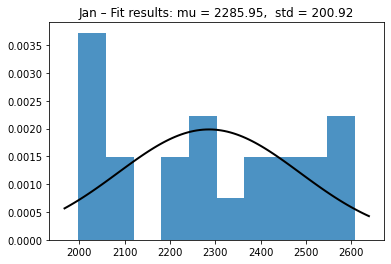

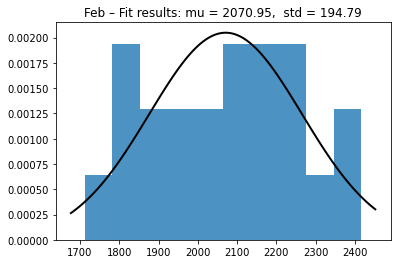

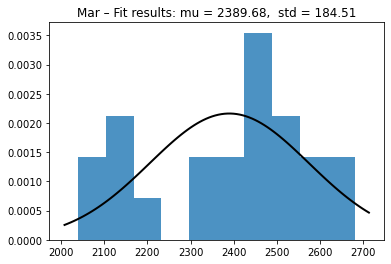

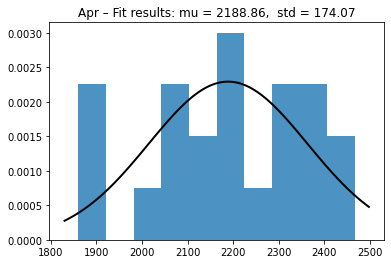

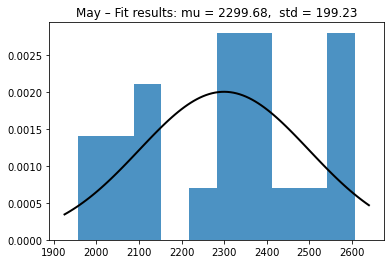

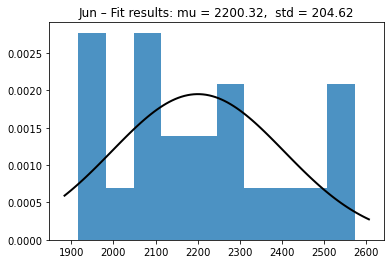

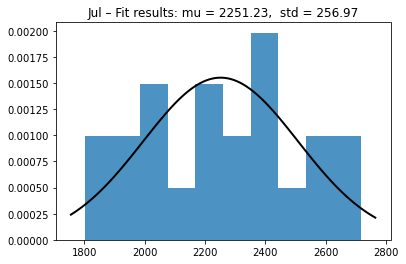

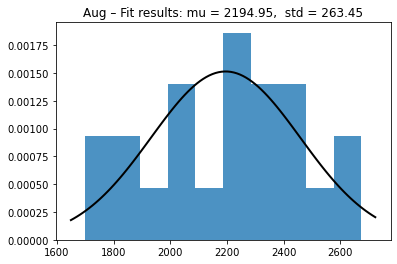

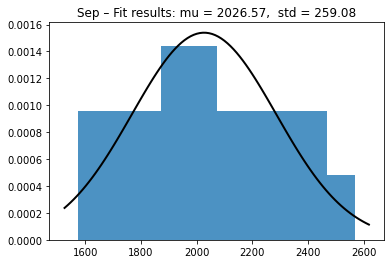

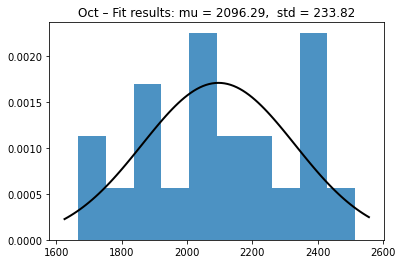

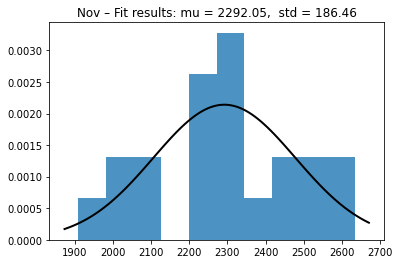

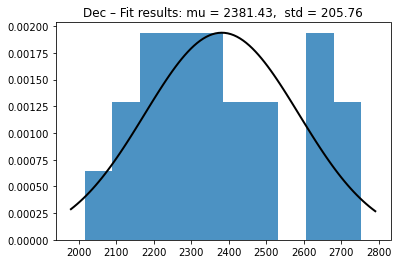

In [22]:
hydro_pds = [] # will have 12 per month
for month in unique_months:
    # Fit a normal distribution to the data:
    _data = monthly_elec.hydroelectric.loc[month]
    mu, std = norm.fit(_data)
    hydro_pds.append((mu, std))

    plt.hist(_data, density=True, alpha=0.8, color='tab:blue')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "{} – Fit results: mu = {:.2f},  std = {:.2f}".format(month, mu, std)
    plt.title(title)

    plt.show()

In [23]:
print(hydro_pds)

[(2285.9545454545455, 200.92275251782422), (2070.9545454545455, 194.7932417328522), (2389.681818181818, 184.5127210109808), (2188.8636363636365, 174.07425151734049), (2299.681818181818, 199.22974092595084), (2200.318181818182, 204.62146567473323), (2251.2272727272725, 256.97469486634844), (2194.9545454545455, 263.45251034410654), (2026.5714285714287, 259.0834709084298), (2096.285714285714, 233.81660352000807), (2292.0476190476193, 186.4593601043443), (2381.4285714285716, 205.76236210702857)]


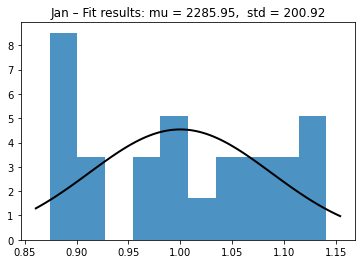

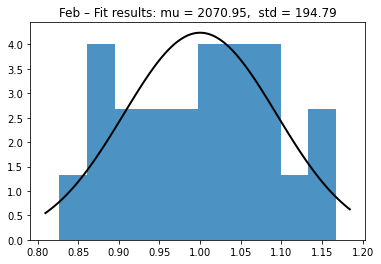

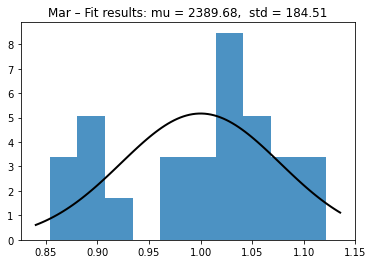

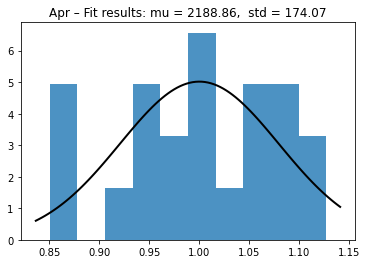

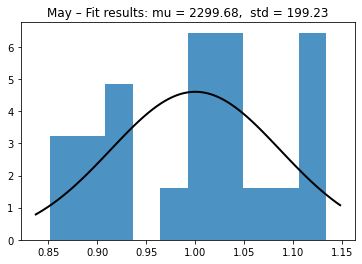

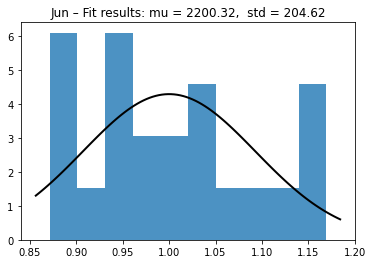

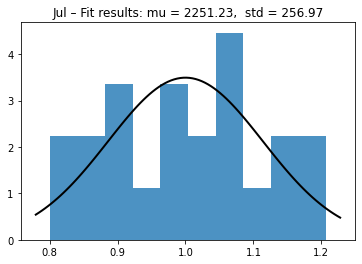

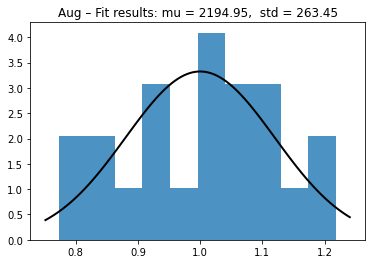

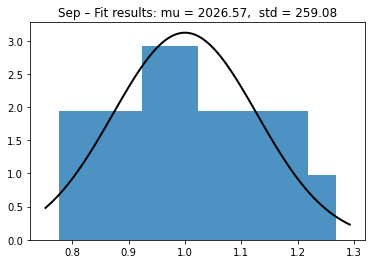

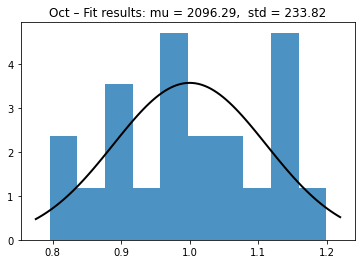

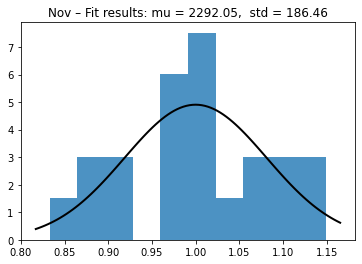

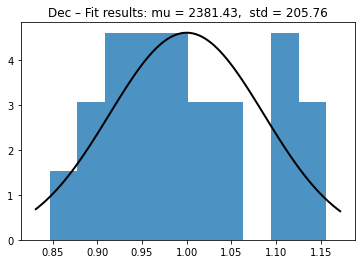

In [24]:
hydro_pds = [] # will have 12 per month
for month in unique_months:
    # Fit a normal distribution to the data:
    _data = monthly_elec.hydroelectric.loc[month]
    mu, std = norm.fit(_data)
    hydro_pds.append((1, std/mu))

    plt.hist(_data/mu, density=True, alpha=0.8, color='tab:blue')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, 1, std/mu)
    plt.plot(x, p, 'k', linewidth=2)
    title = "{} – Fit results: mu = {:.2f},  std = {:.2f}".format(month, mu, std)
    plt.title(title)

    plt.show()

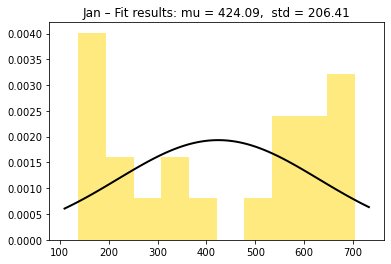

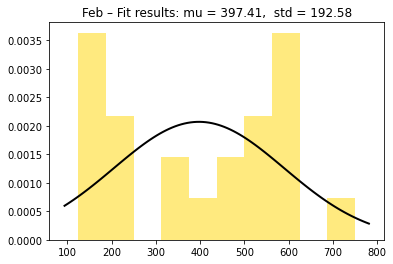

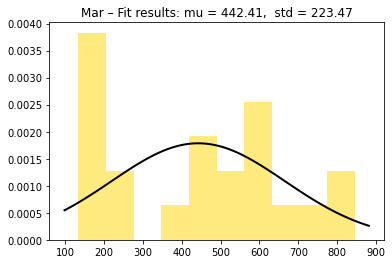

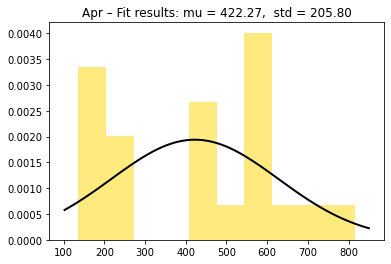

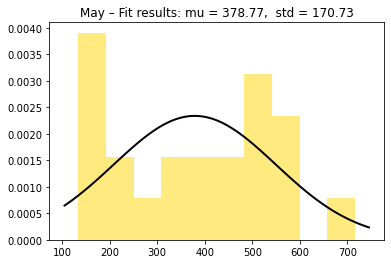

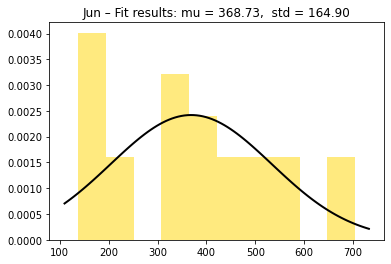

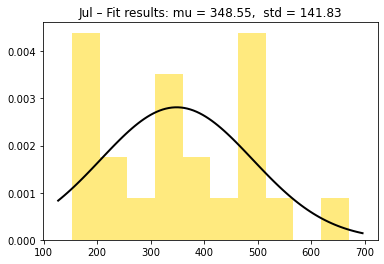

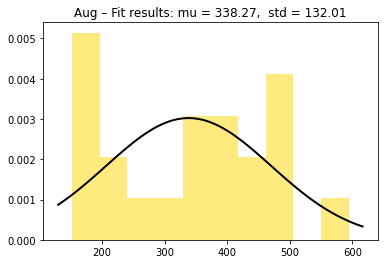

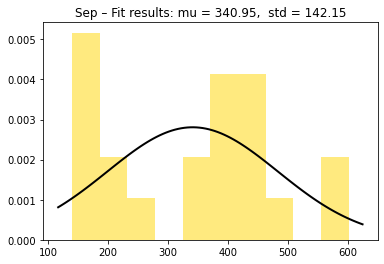

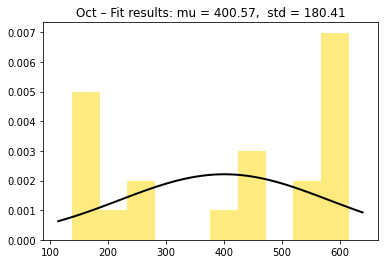

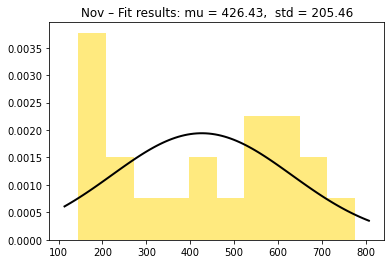

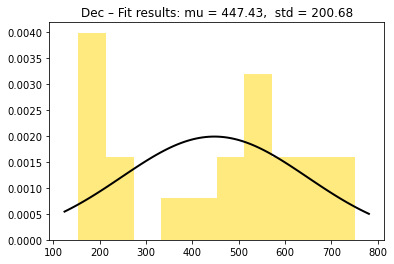

In [25]:
solar_wind_pds = [] # will contain 12
for month in unique_months:
    # Fit a normal distribution to the data:
    _data = monthly_elec.other_renewables.loc[month]
    mu, std = norm.fit(_data)
    solar_wind_pds.append((mu, std))
    
    plt.hist(_data, density=True, alpha=0.5, color='gold')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "{} – Fit results: mu = {:.2f},  std = {:.2f}".format(month, mu, std)
    plt.title(title)

    plt.show()

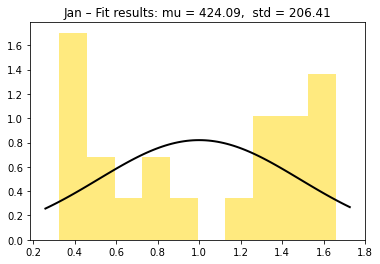

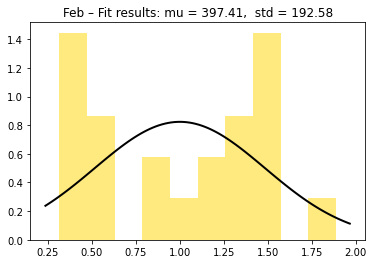

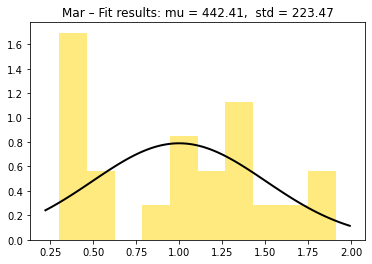

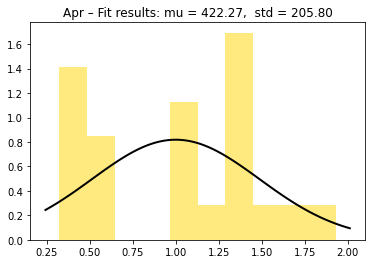

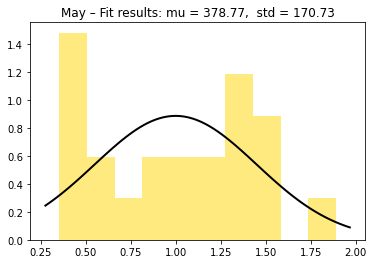

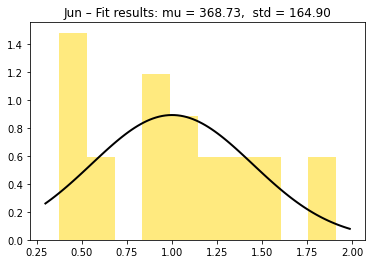

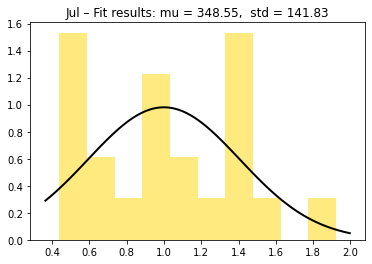

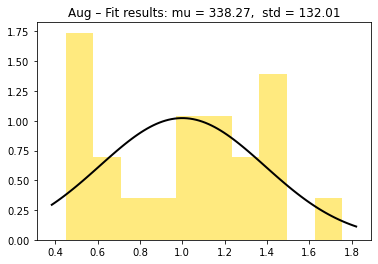

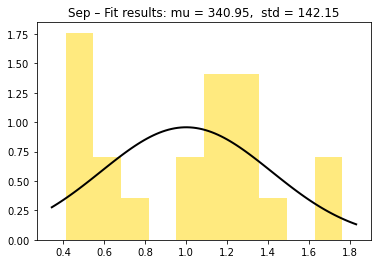

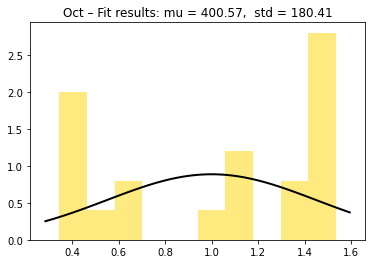

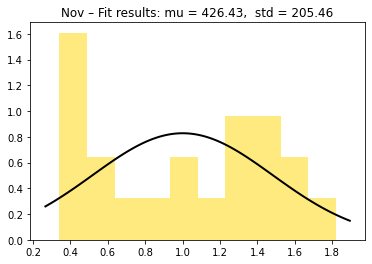

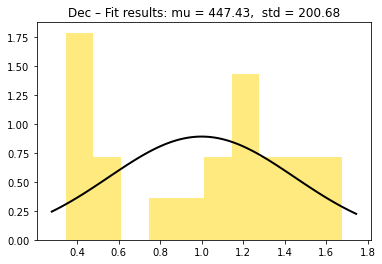

In [26]:
solar_wind_pds = [] # will contain 12
for month in unique_months:
    # Fit a normal distribution to the data:
    _data = monthly_elec.other_renewables.loc[month]
    mu, std = norm.fit(_data)
    solar_wind_pds.append((1, std/mu))
    
    plt.hist(_data/mu, density=True, alpha=0.5, color='gold')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, 1, std/mu)
    plt.plot(x, p, 'k', linewidth=2)
    title = "{} – Fit results: mu = {:.2f},  std = {:.2f}".format(month, mu, std)
    plt.title(title)

    plt.show()

In [27]:
print(solar_wind_pds)

[(1, 0.48670905525976643), (1, 0.48459952733874345), (1, 0.5051287273514139), (1, 0.4873560301992811), (1, 0.45074021810181353), (1, 0.4472125624931032), (1, 0.4069228745962548), (1, 0.3902534959279413), (1, 0.41692917461323725), (1, 0.450393462527484), (1, 0.4818078914157157), (1, 0.44851306460866525)]


***

## Understanding DERs in 2022

In [28]:
cols = [
    'Number of Devices',
    'Rated Electric Generation Per Device (kW)',
    'Primary Fuel',
    'ESS Type',
    'ESS Subtype',
    'Rated Electric Storage Capacity Per Device (kWh)',
    'Equivalent Electrical Storage Capacity Per Device from Cooling Sources (kWh)',
]

short_cols = [
    'quantity',
    'generation',
    'fuel',
    'storage_type',
    'storage_subtype',
    'storage_capacity',
    'cooling_storage_capacity',
]

ders = pd.read_excel('data/nys_der_metrics.xlsx', sheet_name='DE Resources')
ders = ders[cols]
ders.columns = short_cols
ders.head()

,quantity,generation,fuel,storage_type,storage_subtype,storage_capacity,cooling_storage_capacity
0,1,318.99,Solar,NaN,NaN,NaN,NaN
1,2,75.00,Natural Gas,NaN,NaN,NaN,NaN
2,1,65.00,Natural Gas,NaN,NaN,NaN,NaN
3,1,2507.67,Solar,NaN,NaN,NaN,NaN
4,1,2152.08,Solar,NaN,NaN,NaN,NaN


In [29]:
total_gen = ders.generation.sum()
total_electric_storage = ders.storage_capacity.sum()
total_cooling_storage = ders.storage_capacity.sum()

### DER Growth Assumptions 

Per state motor vehicle registrations in 2017, there **4%** of all cars in the US are registered in NYS.

[EEI](https://www.eei.org/News/news/All/eei-projects-26-million-electric-vehicles-will-be-on-us-roads-in-2030#:~:text=The%20number%20of%20EVs%20on,on%20U.S.%20roads%20in%202030.) projects that there will be 26.4M electric cars on the road, meaning 4% of those will be in NYS.

Per [Car and Driver](https://www.caranddriver.com/features/g36278968/best-selling-evs-of-2021/) the number one selling electric car in 2021 was the Tesla Model Y with a battery size of ~80kWhs [source](https://www.caranddriver.com/tesla/model-y/specs).

So let's assume that there's a total of **1,056,000 electric vehicles** (26.4M vehicles * 4% in NYS) with a total storage capacity of 84,480,000 kWhs or 84,480 MWhs of ***additional*** electric storage capacity will be available in 2030.

Let's double the adoption of cooling storage...

In [30]:
# All in MWh
der_stats = [
        {'year': 2022, 'elec_gen': total_gen/1000, 'elec_storage': total_electric_storage/1000, 'cooling_storage': total_electric_storage/1000},
        {'year': 2030, 'elec_gen': total_gen*2.5/1000, 'elec_storage': (total_electric_storage/1000) + 84480, 'cooling_storage': total_electric_storage*2/1000}
    ]

print("DER Capacities by type")
der_stats = pd.DataFrame(der_stats)
der_stats.set_index("year", inplace=True)
der_stats

DER Capacities by type


,elec_gen,elec_storage,cooling_storage
year,,,
2022,2200.199577,358.442,358.442
2030,5500.498943,84838.442,716.884


Operational DER Resources (2022)

Total electric generation (MW): 2200.199577
Total electric storage (MWh):    358.442
Total cooling storage (MWh):     358.442


Estimated DER Resources (2030)

Total electric generation (MW): 5500.4989425
Total electric storage (MWh):   84838.442
Total cooling storage (MWh):     716.884


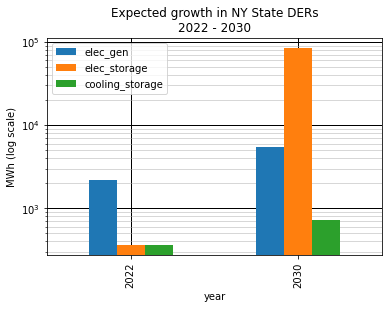

In [31]:
print("Operational DER Resources (2022)\n")
print("Total electric generation (MW): {}".format(total_gen/1000))
print("Total electric storage (MWh):    {}".format(total_electric_storage/1000))
print("Total cooling storage (MWh):     {}".format(total_electric_storage/1000))

print("\n\nEstimated DER Resources (2030)\n")
print("Total electric generation (MW): {}".format(total_gen*2.5/1000))
print("Total electric storage (MWh):   {}".format((total_electric_storage/1000) + 84480))
print("Total cooling storage (MWh):     {}".format(total_electric_storage*2/1000))

der_stats.plot.bar(zorder=5)
plt.yscale('log') # or "log"
plt.ylabel("MWh (log scale)")
plt.grid(which='major', zorder=3, color='k', linewidth=1) # color='r', linestyle='-', linewidth=2
plt.grid(which='minor', zorder=4, linewidth=0.5)
plt.title("Expected growth in NY State DERs\n2022 - 2030")
plt.show()

## Simulating a dymanic electricity market

To raise the stakes that **ScOWL** must content with, we'll have an aggregate supply that is always chasing the demand curve. In order to prevent blackouts, and minimize brownouts, we'll have to rapidly recalcuate the *ephermal distribution trees* for each `Generateor` presently available.

#### In short,

- When we have an excess of supply, our storage resources should kick in.
- When we have an too much demand, a `Generator` should signal to each `Consumer` in their distribution tree to reduce demand (via a `low_capacity` RPC).
- If a `Consumer` does not back off fast enough, it could blackout their whole tree.
- When a `Consumers` region is blackedout, the `Tracker` tries to pair its consumption with another `Generator` and add it to their tree. If it cannot find a `Generator` with available capacity. That `Consumer` gets ***starved***. 
- `Consumer` starvation is a key metric for evaluation.

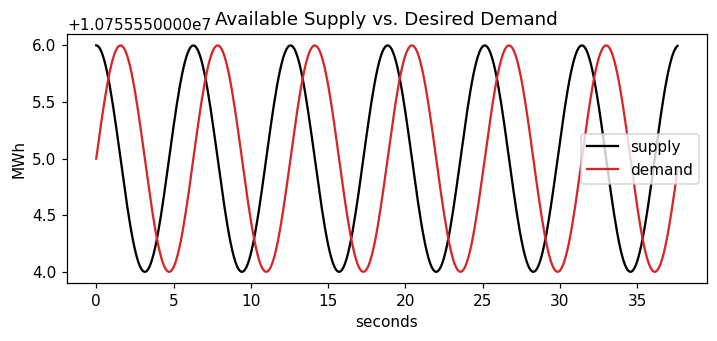

In [32]:
# T is a multiplier that is used to set the timescale of each trial run.
# T may be 12 seconds --> 12 months.
# The base units are seconds
T = 12
T_units = "seconds"
time = np.arange(0,T*np.pi,0.1)
supply = np.cos(time) + g30.mwh.sum()
demand = np.sin(time) + g30.mwh.sum()
data = {
    "supply": supply,
    "demand": demand
}
df = pd.DataFrame(data, index=time)

fig, ax1 = plt.subplots(figsize=(7.5,3), dpi=110)

ax1.plot(df['supply'], color="black")
ax1.plot(df['demand'], color="tab:red")            
ax1.set_ylabel("MWh")
ax1.set_xlabel(T_units)
ax1.set_title("Available Supply vs. Desired Demand")
plt.legend(["supply","demand"])

plt.show()

## How many generators are online today?

State codes:

In [33]:
pd.DataFrame([["NY", 36],["PA", 42],["MA", 25],["NJ", 34]], columns=("state","code")).set_index("state").T

state,NY,PA,MA,NJ
code,36,42,25,34


In [34]:
gen_facilities = pd.read_csv('data/2021_generation_facilities.csv',skiprows=1)
gen_facilities.head(3)

,"Owner, Operator, and/or Billing Organization",station unit,zone,PTID,town,county,st,In-Service Date,Name Plate Rating (V) MW,cris_summer,cris_winter,cap_summer,cap_winter,D U A L,Unit Type,Type 1,Type 2,gwh,Notes
0,Arkwright Summit Wind Farm,Arkwright Summit Wind Farm,A,323751,Arkwright,13,36,9/1/18,78.4,78.4,78.4,78.4,78.4,NaN,WT,WND,NaN,255.8,NaN
1,"Astoria Energy II, LLC",Astoria Energy 2 - CC3,J,323677,Queens,81,36,7/1/11,330.0,288.0,376.3,285.7,329.5,YES,CC,NG,FO2,2899.9,(G)
2,"Astoria Energy II, LLC",Astoria Energy 2 - CC4,J,323678,Queens,81,36,7/1/11,330.0,288.0,376.3,285.7,329.5,YES,CC,NG,FO2,0.0,NaN


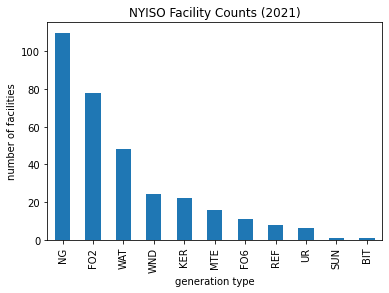

In [35]:
# many hydro facilities produced no electricity in 2021, maybe they are old?
fig = gen_facilities[gen_facilities.gwh > 0]["Type 1"].value_counts().plot.bar()
fig.set_title("NYISO Facility Counts (2021)")
fig.set_ylabel("number of facilities")
fig.set_xlabel("generation type")
plt.show()

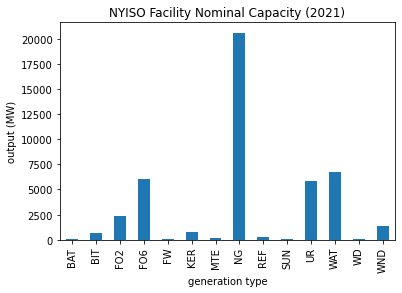

In [36]:
fig = gen_facilities.groupby("Type 1").sum()["Name Plate Rating (V) MW"].plot.bar()
fig.set_title("NYISO Facility Nominal Capacity (2021)")
fig.set_ylabel("output (MW)")
fig.set_xlabel("generation type")
plt.show()

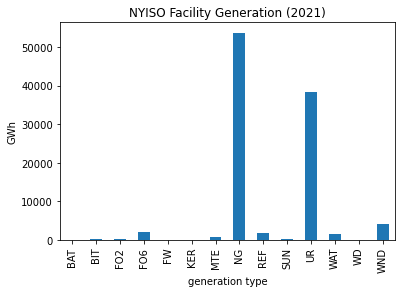

In [37]:
fig = gen_facilities.groupby("Type 1").sum()["gwh"].plot.bar()
fig.set_title("NYISO Facility Generation (2021)")
fig.set_ylabel("GWh")
fig.set_xlabel("generation type")
plt.show()

### Average output by facility type

In [38]:
num_facilities = gen_facilities[gen_facilities.gwh > 0]["Type 1"].value_counts()
nominal_capacity = gen_facilities.groupby("Type 1").sum()["Name Plate Rating (V) MW"]
avg_facility_cap = nominal_capacity / num_facilities
avg_facility_cap = np.round(avg_facility_cap[avg_facility_cap > 0]).astype(int)
avg_facility_cap

BIT    655
FO2     30
FO6    547
KER     34
MTE      8
NG     188
REF     30
SUN     56
UR     975
WAT    140
WND     57
dtype: int64

***

# Testbed Parameters

## Part 1: Instantiating peers

### Generators

Drawing from the stats above, we will instate generators proportional to:
1. Total generation capacity
2. Generation capacity by unit type
3. Number of units as function of average unit size

Per the 2021 "Gold Book" the forecasted total capacity is expected to be: **41,071 MW**

Per the 2021 "Gold Book" the forecasted Summer Peak Demand to be: **32,121 MW**

Per the 2021 "Gold Book" the forecasted Winter Peak Demand to be: **25,275 MW**


In [39]:
# total capacity (MW)
nominal_cap = 41071
# Summer peak demand (MW)
summer_peak = 32121
# Winter peak demand (MW)
winter_peak = 25275

In [40]:
std_index_counts = {
    "hydroelectric": ["WAT"],
    "nuclear": ["UR"],
    "natural gas-fired": ["NG","MTE"],
    "utility-scale solar": ["SUN"],
    "land-based wind": ["WND"],
    "petroleum-fired": ["BIT","KER","FO2","FO6","REF"]
}

In [41]:
# # uncomment to view exact number of facilities, by sub-type
# gen_facilities[gen_facilities.gwh > 0]["Type 1"].value_counts()

In [42]:
def sumAndReindex(data, indexes):
    reformatted_data = []
    for t in indexes:
        reformatted_data.append([t, data[indexes[t]].sum()]) 
    return reformatted_data

facil_counts = sumAndReindex(gen_facilities[gen_facilities.gwh > 0]["Type 1"].value_counts(), std_index_counts)
facil_counts = pd.DataFrame(facil_counts, columns=["type","counts"]).set_index("type")
print("True Count of Generation Facilities by Type")
facil_counts.T

True Count of Generation Facilities by Type


type,hydroelectric,nuclear,natural gas-fired,utility-scale solar,land-based wind,petroleum-fired
counts,48,6,126,1,24,120


In [43]:
def avgAndReindex(data, indexes):
    reformatted_data = []
    for t in indexes:
        reformatted_data.append([t, data[indexes[t]].mean()]) 
    return reformatted_data

avg_gen = avgAndReindex(avg_facility_cap, std_index_counts)
avg_gen = pd.DataFrame(avg_gen, columns=["type","capacity_mw"]).set_index("type")
print("Average Nominal Generation Facility Capacity (MW)")
avg_gen.T

Average Nominal Generation Facility Capacity (MW)


type,hydroelectric,nuclear,natural gas-fired,utility-scale solar,land-based wind,petroleum-fired
capacity_mw,140.0,975.0,98.0,56.0,57.0,259.2


## Compute number of generation facilities to instantiate 

\<facility_type\><sub>total</sub> = total_generation<sub>nominal</sub> / generation_per_facility<sub>average</sub>

In [44]:
# add better notes HERE for parametric facilities counts
facil_counts = np.round((nominal_cap * g22.portion / avg_gen.T))
facil_counts = facil_counts.T.sort_values('capacity_mw', ascending=False)
facil_counts.columns = ["counts"]
facil_counts.T

type,natural gas-fired,hydroelectric,land-based wind,utility-scale solar,nuclear,petroleum-fired,distributed solar,offshore wind
counts,246.0,51.0,21.0,16.0,8.0,0.0,NaN,NaN


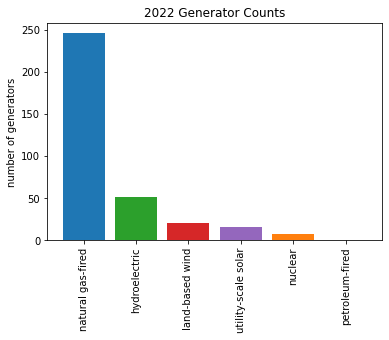

In [45]:
plt.bar(facil_counts.index, facil_counts.counts.values, color=colors.color[facil_counts.index].values)
plt.title("2022 Generator Counts")
plt.ylabel("number of generators")
plt.xticks(rotation=90)
plt.show()

In [46]:
future_facil_counts = np.ceil(facil_counts.T * capacity_increase).T
future_facil_counts[np.isnan(future_facil_counts.counts)] = 0
future_facil_counts.counts = future_facil_counts.counts.astype(int)
future_facil_counts.T

type,distributed solar,hydroelectric,land-based wind,natural gas-fired,nuclear,offshore wind,petroleum-fired,utility-scale solar
counts,0,89,46,50,10,0,0,76


In [47]:
future_facil_counts.loc[facil_counts.index]

,counts
type,
natural gas-fired,50
hydroelectric,89
land-based wind,46
utility-scale solar,76
nuclear,10
petroleum-fired,0
distributed solar,0
offshore wind,0


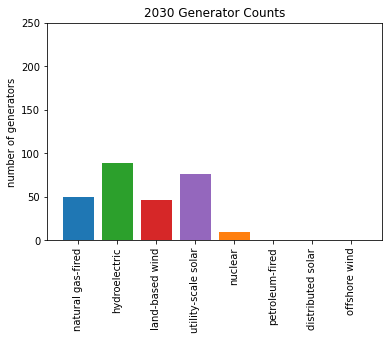

In [48]:
plt.bar(
    future_facil_counts.loc[facil_counts.index].index,
    future_facil_counts.loc[facil_counts.index].counts,
    color=colors.color[future_facil_counts.loc[facil_counts.index].index].values)
plt.title("2030 Generator Counts")
plt.ylabel("number of generators")
plt.ylim(0,250)
plt.xticks(rotation=90)
plt.show()

In [49]:
final_gen_stats = pd.concat([facil_counts, avg_gen], axis=1)
print("We'll instantiate our testbed with these parameters:")
final_gen_stats.T

We'll instantiate our testbed with these parameters:


type,natural gas-fired,hydroelectric,land-based wind,utility-scale solar,nuclear,petroleum-fired,distributed solar,offshore wind
counts,246.0,51.0,21.0,16.0,8.0,0.0,NaN,NaN
capacity_mw,98.0,140.0,57.0,56.0,975.0,259.2,NaN,NaN


***

### Consumers

The most recently published dataset is from 2018. We'll base our portion of consumers based on that.

In [50]:
elec_customers = pd.read_csv('data/electricity_sales_by_customer_GWh.csv').set_index("Year").drop("Grand Total", axis=1)
portion_elec_customers = elec_customers.loc[2018] / elec_customers.loc[2018].sum() 

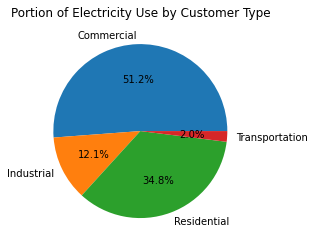

In [51]:
plt.pie(portion_elec_customers, labels=portion_elec_customers.index, autopct='%.1f%%')
plt.title("Portion of Electricity Use by Customer Type")
plt.show()

According to [Census.gov](https://www.census.gov/quickfacts/NY), there are **8,531,063 housing units** in New York State, as of 2021.

According to the [NYSERDA commercial baseline study](https://www.nyserda.ny.gov/about/publications/building-stock-and-potential-studies/commercial-statewide-baseline-study), there are **367,223 commercial buildings** in New York State. (Vol 1., pg.13)

For simplicity, we'll assume that **transportation** and **industrial** end uses have ***fixed*** energy consumption.

In [52]:
res_units = 8531063 
com_units = 367223

In [53]:
# Average consumption by unit type (MW)
consump_by_cust_type = summer_peak * portion_elec_customers
consump_by_cust_type

Commercial        16441.956826
Industrial         3872.841925
Residential       11173.332131
Transportation      632.869118
Name: 2018, dtype: float64

In [54]:
res_unit_consump = consump_by_cust_type["Residential"] / res_units
com_unit_consump = consump_by_cust_type["Commercial"] / com_units
print("Residential Units:          {}".format(res_units))
print("Avg. res unit consumption:  {} MW".format(np.round(res_unit_consump, 5)))
print("Commercial Units:           {}".format(com_units))
print("Avg. com. unit consumption: {} MW".format(np.round(com_unit_consump, 5)))

Residential Units:          8531063
Avg. res unit consumption:  0.00131 MW
Commercial Units:           367223
Avg. com. unit consumption: 0.04477 MW


We'll use this [source ](https://www.perchenergy.com/blog/energy/what-appliances-use-most-electricity-home)for energy break downs for residential units. TV has been combined with plug loads.

In [55]:
res_elec_by_use = [
    {"load": "hvac", "portion": 0.45, "deferrable_for": 60*10},
    {"load": "hot_water", "portion": 0.12, "deferrable_for": 60*5},
    {"load": "lighting", "portion": 0.10, "deferrable_for": 0},
    {"load": "fridge", "portion": 0.08, "deferrable_for": 60*3},
    {"load": "washer_dryer", "portion": 0.05, "deferrable_for": 60*15},
    {"load": "oven", "portion": 0.03, "deferrable_for": 0},
    {"load": "dishwasher", "portion": 0.02, "deferrable_for": 60*30},
    {"load": "other", "portion": 0.15, "deferrable_for": 60*30},
]

In [56]:
print("Prototypical energy loads (residential)")
res_elec_by_use = pd.DataFrame(res_elec_by_use)
res_elec_by_use

Prototypical energy loads (residential)


,load,portion,deferrable_for
0,hvac,0.45,600
1,hot_water,0.12,300
2,lighting,0.10,0
3,fridge,0.08,180
4,washer_dryer,0.05,900
5,oven,0.03,0
6,dishwasher,0.02,1800
7,other,0.15,1800


***

In [57]:
res_elec_by_use.portion.sum()

1.0

# Trackers

Trackers must maintain *ephemeral distribution trees*, graphs that connect a `Consumer`  to a `Generator` with  spare capacity. As `Consumer` demand increases, `Generators` may be forced to `disconnect()` one or more consumers to maitain a `safetyThreshold`.

The following is a sketch of the tracker microservice.

In [58]:
class Tracker:
    def __init__(self):
        self.Trees = []
        self.Consumers = []
        self.Generators = []
    
    def balanceTrees(self):
        """Balance all trees managed by the tracker"""
        pass
    
    def findGenerator(self, consumer):
        """Find a generator with spare capacity for a consumer to matched with"""
        pass
    
    def findConsumers(self, generator):
        """Find a consumer with to absorb spare generation capacity"""
        pass
    
    def shedLoad(self, generator):
        """Pick consumers to disconnect from a generator to maintain the safety threshold"""
        pass
    
    def registerGenerator(self, generator):
        """Add a generator to self.Generators"""
        pass
    
    def registerConsumer(self, consumer):
        """Add a consumer to self.Consumers"""
        pass
    

Trackers must store metadata about each `Generator` and `Consumer` that they are responsible for. The abbreviated set of `Peer` metadata the tracker must store is captured below:

In [59]:
SEED = 42 # for deterministic hashing with MurmurHash3

class mPeer:
    def __init__(self, addr):
        self.addr = addr #IPV4 address
        self.id = self.setHash()
    
    def getAddr(self):
        return self.addr
    
    def setHash(self):
        import mmh3
        import secrets
        import warnings
#         warnings.filterwarnings('ignore')
        self.id = mmh3.hash(self.addr + secrets.token_hex(2),SEED) # secrets.token_hex is non-deterministic...
        return self.id

class mGenerator(mPeer):
    def __init__(self, addr, nominal_capacity, kind):
        self.addr = addr #IPV4 address
        self.id = self.setHash()
        
        self.kind = kind
        self.nominal_cap = nominal_capacity # MW
        
        self.cur_cap = 0    # MW
        self.cur_demand = 0 # MW

class mConsumer(mPeer):
    def __init__(self, addr, avg_consump, kind, desired_consump=None, deferrable_consump=0, demand_responsive_consump=0):
        self.addr = addr #IPV4 address
        self.id = self.setHash()
        
        self.avg_consump = avg_consump               # MW
        self.deferrable_consump = deferrable_consump # MW
        self.dr_consump = demand_responsive_consump  # MW
        
        if desired_consump is None:
            self.desired_consump = self.avg_consump  # MW
        
        self.cur_consump = 0 # current consumption in MW        

class mStorage(mConsumer):
    def __init__(self, addr, capacity):
        self.addr = addr  #IPV4 address
        self.id = self.setHash()

        self.capacity = 0 # MW

In [60]:
# Test
# this will return a new value each time because of the use of the non-determinstic nonce...
# I don't think that's ideal.
p = mPeer("192.168.1.2:3003")
print(p.id)

-1545660612


/var/folders/51/y1pfjrgx6w9czpjg5nxx6fnm0000gn/T/ipykernel_15544/1645451492.py:16: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  self.id = mmh3.hash(self.addr + secrets.token_hex(2),SEED) # secrets.token_hex is non-deterministic...


## Assigning Buckets for Generator Trackers

To evenly distribute the labor of generating distribution trees. We'll need to assign a fixed number of buckets to filter each `Generator.id` into.

I'll be assuming the use of the d430 resource type on emulab. It has:
- 16 CPU cores @ 2.4Hz
- 64 GB DDR4 RAM @ 2133MT/s

Accordingly, we'll assume **8-16 `Tracker` buckets**.

### Method

Bucket assignment works as follows:

In [61]:
HASH_SIZE = 32

# def assignBucket(hash_result, num_buckets=8):
#     # map hash_result in to the range [0,1]
#     hash_result += 2**(HASH_SIZE-1)
#     p = hash_result / 2**(HASH_SIZE)
#     b = int(np.round(p * (num_buckets)))
#     if b >= num_buckets: b = 0 
#     return b

In [62]:
np.linspace((2**31 * -1), (2**31), 8+1, dtype=int)

array([-2147483648, -1610612736, -1073741824,  -536870912,           0,
         536870912,  1073741824,  1610612736,  2147483648])

In [63]:
def AssignBucket(hash_result, num_buckets=8, break_points = None, hash_size=HASH_SIZE):
    break_points = break_points
    if break_points is None:
        break_points = np.linspace((2**(hash_size-1) * -1), (2**(hash_size-1)), num_buckets + 1, dtype=int)
    bucket = None
    for i in range(num_buckets):
        if (hash_result >= break_points[i]) and (hash_result < break_points[i+1]):
            bucket = i
            break
    return bucket

AssignBucket(2147483647)

7

In [64]:
def LoadTrackers(path):
    file = ""
    with open(path, 'r') as reader:
        file = reader.read()
    return file.split('\n')

hosts = LoadTrackers('sim/2030/trackers/config/tracker_addrs.txt')

In [65]:
def GenTrackerLookup(num_trackers: int, starting_port: int = 32000, hosts = 'localhost'):
    lookup = {}
    for i in range(num_trackers):
        lookup[i] = {'host_id': 0, 'addr': 'localhost', 'port': str(starting_port + i)}
    if hosts != 'localhost':
        for i in range(num_trackers):
            lookup[i]['host_id'] = i % len(hosts)
            lookup[i]['addr'] = hosts[i % len(hosts)]
    return lookup

GenTrackerLookup(10, hosts=hosts)

{0: {'host_id': 0, 'addr': '192.168.1.1', 'port': '32000'},
 1: {'host_id': 1, 'addr': '192.168.1.2', 'port': '32001'},
 2: {'host_id': 2, 'addr': '192.168.1.3', 'port': '32002'},
 3: {'host_id': 3, 'addr': '192.168.1.4', 'port': '32003'},
 4: {'host_id': 0, 'addr': '192.168.1.1', 'port': '32004'},
 5: {'host_id': 1, 'addr': '192.168.1.2', 'port': '32005'},
 6: {'host_id': 2, 'addr': '192.168.1.3', 'port': '32006'},
 7: {'host_id': 3, 'addr': '192.168.1.4', 'port': '32007'},
 8: {'host_id': 0, 'addr': '192.168.1.1', 'port': '32008'},
 9: {'host_id': 1, 'addr': '192.168.1.2', 'port': '32009'}}

In [66]:
tracker_lookup = {
    0 : {"addr": 'localhost', "port": '32000'},
    1 : {"addr": 'localhost', "port": '32001'}, 
}
tracker_lookup

{0: {'addr': 'localhost', 'port': '32000'},
 1: {'addr': 'localhost', 'port': '32001'}}

### Checking for correctness

In [69]:
r = range(-1 * 2**(HASH_SIZE-1), 2**(HASH_SIZE-1) + 1, 2**16)
bucket = []
for sample in r:
    bucket.append(AssignBucket(sample))

In [70]:
results = pd.DataFrame(bucket)

In [71]:
pd.DataFrame(results.value_counts(),columns=["bucket_size"]).sort_index().T

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
bucket_size,8192,8192,8192,8192,8192,8192,8192,8192


In [72]:
# import mmh3
# h = mmh3.hash('snake')
# # print(h)
# for b in range(-2147483648,2147483647,8):
#     print()

np.linspace((2**31 * -1), (2**31 -1), 8, dtype=int)

array([-2147483648, -1533916892,  -920350136,  -306783379,   306783377,
         920350134,  1533916890,  2147483647])

In [73]:
len('101011011110011101011100110011')

30

In [74]:
# for example
TRACKER_ID = 2

def ComputeBucket(num_buckets: int, bucket_id: int = TRACKER_ID, hash_size: int = 32):
    import numpy as np
    break_points = np.linspace((2**(hash_size-1) * -1), (2**(hash_size-1)), num_buckets + 1, dtype=int)
    print(break_points)
    lower = break_points[bucket_id]
    upper = break_points[bucket_id+1]
    return lower, upper

ComputeBucket(8, 1)

[-2147483648 -1610612736 -1073741824  -536870912           0   536870912
  1073741824  1610612736  2147483648]


(-1610612736, -1073741824)

## Tracker Mock Up

How do Trackers get their `Generator` assignments?

- a loadbalancer?

What's the use case (bootstrapping)?
1. New `Generator` comes online.
2. It pings a server to know where which `Tracker` it should be assigned to.
3. When that server responds, the `Geneterator` connects with that `Tracker` so it may be given an ephemeral distribution tree.

### Bootstrapping Server Mockup

In [75]:
# a new generator comes online,
# it pings the bootstrapping server for the tracker_id and ip_address to reach out to:
class GeneratorBootstrappingServer():
    def __init__(self):
        self.trackers = {
            1 : "192.168.1.1:3001",
            2 : "192.168.1.1:3002",
            3 : "192.168.1.1:3003",
            4 : "192.168.1.1:3004",
            5 : "192.168.1.2:3001",
            6 : "192.168.1.2:3002",
            7 : "192.168.1.2:3003",
            8 : "192.168.1.2:3004",
        }
        self.HASH_SIZE = 32 # if using mmh3.hash()
    
    def assign_bucket(self, gen_addr, num_buckets=8):
        # add some a random nonce
        import mmh3
        import secrets
        import warnings
        # hashing done at the bootstrapping server so that a compromised generator can't 
        # intentionally overload a tracker by trying to register generators with the same ip and "nonce"
        # secrets.token_hex is non-deterministic...
        hash_result = mmh3.hash(gen_addr + secrets.token_hex(2),SEED)
        
        # get the hash_result into the range of an unsigned 32-bit int
        hash_result += 2**(self.HASH_SIZE-1)

        # map hash_result in to the range [0,1]
        p = hash_result / 2**(self.HASH_SIZE)
        
        # assign to specific bucket
        b = int(np.round(p * (num_buckets)))
        if b >= num_buckets: b = 0 # clean up results
        
        # return the bucket to the client (Generator)
        return b

In [76]:
gbs = GeneratorBootstrappingServer()

Sanity Check

In [77]:
peers_to_sort = 1000

### Correctness Check No. 2

In [78]:
generator_mdata = []
for kind in final_gen_stats[final_gen_stats.counts > 0].index:
    for facil in range(final_gen_stats.loc[kind].counts.astype(int)):
        generator_mdata.append(
            mGenerator(
                '192.168.1.0:65535',
                final_gen_stats.loc[kind].capacity_mw,
                kind
            )
        )
    print("Created: {} generators".format(kind))

print("\nTotal Generators created: {}".format(len(generator_mdata)))

Created: natural gas-fired generators
Created: hydroelectric generators
Created: land-based wind generators
Created: utility-scale solar generators
Created: nuclear generators

Total Generators created: 342


/var/folders/51/y1pfjrgx6w9czpjg5nxx6fnm0000gn/T/ipykernel_15544/1645451492.py:16: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  self.id = mmh3.hash(self.addr + secrets.token_hex(2),SEED) # secrets.token_hex is non-deterministic...


/var/folders/51/y1pfjrgx6w9czpjg5nxx6fnm0000gn/T/ipykernel_15544/658864588.py:25: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  hash_result = mmh3.hash(gen_addr + secrets.token_hex(2),SEED)


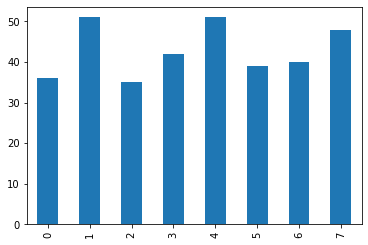

In [79]:
# Create bootsctrapping server
gbs = GeneratorBootstrappingServer()

tracker_assignments = []
for generator in generator_mdata:
    tracker_assignments.append([gbs.assign_bucket(generator.addr)])


pd.DataFrame(tracker_assignments)[0].value_counts().sort_index().plot.bar()
plt.show()

***

## Memory allocation test

Let's see how much memory it takes to store the basic data about each peer.

Before instantiation of `Generators` this notebook has used **254.4 MB** of memory.

We'll now instantiate the following number of `Peers`, with dummy data.

In [80]:
final_gen_stats.T

type,natural gas-fired,hydroelectric,land-based wind,utility-scale solar,nuclear,petroleum-fired,distributed solar,offshore wind
counts,246.0,51.0,21.0,16.0,8.0,0.0,NaN,NaN
capacity_mw,98.0,140.0,57.0,56.0,975.0,259.2,NaN,NaN


In [81]:
generator_mdata = []
for kind in final_gen_stats[final_gen_stats.counts > 0].index:
    for facil in range(final_gen_stats.loc[kind].counts.astype(int)):
        generator_mdata.append(
            mGenerator(
                '192.168.1.0:65535',
                final_gen_stats.loc[kind].capacity_mw,
                kind
            )
        )
    print("Created: {} generators".format(kind))

print("\nTotal Generators created: {}".format(len(generator_mdata)))

Created: natural gas-fired generators
Created: hydroelectric generators
Created: land-based wind generators
Created: utility-scale solar generators
Created: nuclear generators

Total Generators created: 342


/var/folders/51/y1pfjrgx6w9czpjg5nxx6fnm0000gn/T/ipykernel_15544/1645451492.py:16: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  self.id = mmh3.hash(self.addr + secrets.token_hex(2),SEED) # secrets.token_hex is non-deterministic...


In [82]:
# Inspect sample
print("type:    ", generator_mdata[256].kind)
print("addr:    ", generator_mdata[256].addr)
print("capacity:", generator_mdata[256].nominal_cap, "MW")

type:     hydroelectric
addr:     192.168.1.0:65535
capacity: 140.0 MW


After instantiation of 342 `Generators` this notebook has used **254.4 MB** of memory. So, holding all generators in memory requires **3.2 MB** of memory

Before instantiation of `Consumers` this notebook has used **273.2 MB** of memory.

We'll now instantiate the following number of `Peers`, with dummy data.


In [83]:
print("Residential Units:          {}".format(res_units))
print("Avg. res unit consumption:  {} MW".format(np.round(res_unit_consump, 5)))
print("Commercial Units:           {}".format(com_units))
print("Avg. com. unit consumption: {} MW".format(np.round(com_unit_consump, 5)))

Residential Units:          8531063
Avg. res unit consumption:  0.00131 MW
Commercial Units:           367223
Avg. com. unit consumption: 0.04477 MW


In [84]:
final_consumer_stats = pd.DataFrame(
    [
        {"counts": res_units, "avg_consump": res_unit_consump},
        {"counts": com_units, "avg_consump": com_unit_consump}
    ],
    index=["residential", "commercial"]
)
final_consumer_stats

,counts,avg_consump
residential,8531063,0.001310
commercial,367223,0.044774


In [85]:
consumer_mdata = []
consumers_created = 0
for kind in final_consumer_stats[final_consumer_stats.counts > 0].index:
    print(kind)
    for consumer in range(final_consumer_stats.loc[kind].counts.astype(int)):
        consumer_mdata.append(
            mConsumer(
                '192.168.1.0:65534',
                final_consumer_stats.loc[kind].avg_consump,
                kind
            )
        )
        consumers_created += 1
        if consumers_created >= 10000: break

residential


/var/folders/51/y1pfjrgx6w9czpjg5nxx6fnm0000gn/T/ipykernel_15544/1645451492.py:16: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats
  self.id = mmh3.hash(self.addr + secrets.token_hex(2),SEED) # secrets.token_hex is non-deterministic...


commercial


In [86]:
print("Created: {} consumers".format(len(consumer_mdata)))

Created: 10001 consumers


In [87]:
mem_per_consumer = np.round(( 493.2 - 254.4 ) / 1000002, 8)
mem_per_consumer

0.0002388

Before instantiation of `Consumers` this notebook has used **254.4 MB** of memory.

After instantiation of `Consumers` this notebook has used **493.2 MB** of memory.

So the average memory per consumer is: **0.0002388 MB**


So, to manage all the `Consumers` it would require:

In [88]:
print(final_consumer_stats.counts.sum() * mem_per_consumer, "MB of memory")

2124.9106968 MB of memory


Or, about **2GB**

***

## Energy Mix Generation Scripts

We need to start by instantiating some peers. We'll do this at a fixed ratio of `Consumer`s and `Generator`s, **20,000:1**.

In [89]:
CTG = 20000/1

In [90]:
num_generators = 1 # multiplies the CTG rate to increate the number of consumers and generators

In [91]:
future_facil_counts[future_facil_counts == 0] = 1
future_facil_portions = pd.DataFrame(future_facil_counts, index=facil_counts.index)
future_facil_portions.columns = ["2030_portions"]
future_facil_portions["2030_portions"] = future_facil_portions["2030_portions"] / future_facil_portions["2030_portions"].sum()
future_facil_portions.T

type,natural gas-fired,hydroelectric,land-based wind,utility-scale solar,nuclear,petroleum-fired,distributed solar,offshore wind
2030_portions,0.182482,0.324818,0.167883,0.277372,0.036496,0.00365,0.00365,0.00365


In [92]:
# uncomment to save these portions,
# then relocate from disk 
portions_path = 'sim/2030/generators/config/portions.csv'
future_facil_portions.to_csv(portions_path)
future_facil_portions = pd.read_csv(portions_path).set_index("type")
future_facil_portions.T

type,natural gas-fired,hydroelectric,land-based wind,utility-scale solar,nuclear,petroleum-fired,distributed solar,offshore wind
2030_portions,0.182482,0.324818,0.167883,0.277372,0.036496,0.00365,0.00365,0.00365


This function computes the **number** and **types** of generation facilities to instantiate for the trial.

In [93]:
def getRandFacility(_df, num_facilities=1, seed=10):
    import numpy as np
    """you must pass dataframe with facility types as the index and the portions as the first column"""
    
    # format incoming data
    df = _df # we want a copy
    col_0 = df.columns[0]
    df.sort_values(col_0, ascending=False, inplace=True)
    portions = df[col_0]
    
    # compute breakpoints
    df["breakpoint"] = [np.sum(portions[:i+1]) for i, _ in enumerate(portions.values)]
    
    # create place to store output
    output = df.index

    # use a deterministic PRN
    np.random.seed(seed) # default is 10
    
    # compute the facility determined by the result and the breakpoint
    df["counts"] = [0] * len(df)
    for i in range(num_facilities):
        result = np.random.random()
        for kind in df.index:
            if result <= df.loc[kind].breakpoint:
                df.at[kind,"counts"] =  df.at[kind,"counts"] + 1
                break
    return df

Change this to alter the number of generators in the simulation

In [239]:
num_generators = 5

In [240]:
gen_to_instantiate = getRandFacility(future_facil_portions, num_generators) # set above
gen_to_instantiate = pd.concat([gen_to_instantiate, avg_gen], axis=1)
gen_to_instantiate.at["offshore wind", "capacity_mw"] = gen_to_instantiate.at["land-based wind", "capacity_mw"]
#  home solar outout = 250 W per panel * 25 panels / 1000000 W per MW
gen_to_instantiate.at["distributed solar", "capacity_mw"] = ((250 * 25) / 10**6)
gen_to_instantiate["total_output"] = gen_to_instantiate["counts"] * gen_to_instantiate["capacity_mw"]

print("Total Capacity (nominal) of {} Generators: {} MW".format(num_generators, gen_to_instantiate.total_output.sum()))
gen_to_instantiate.drop(["2030_portions","breakpoint"],axis=1).T

Total Capacity (nominal) of 5 Generators: 490.0 MW


type,hydroelectric,utility-scale solar,natural gas-fired,land-based wind,nuclear,petroleum-fired,distributed solar,offshore wind
counts,1.0,1.0,3.0,0.0,0.0,0.0,0.00000,0.0
capacity_mw,140.0,56.0,98.0,57.0,975.0,259.2,0.00625,57.0
total_output,140.0,56.0,294.0,0.0,0.0,0.0,0.00000,0.0


https://www.cnet.com/home/energy-and-utilities/find-out-how-many-solar-panels-you-need-to-power-your-house/

Let's investigate the output visually.

total generation facilities: 5
total generation capacity:   490 MW


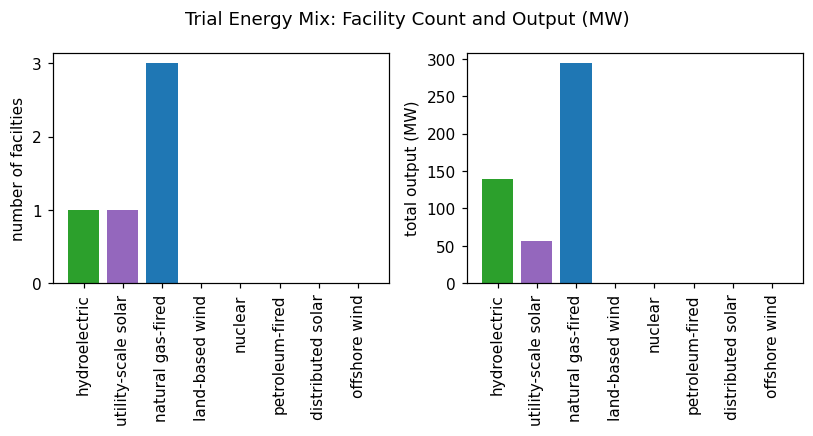

In [241]:
from matplotlib.ticker import MaxNLocator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5,4), dpi=110)
fig.suptitle('Trial Energy Mix: Facility Count and Output (MW)')

_index = gen_to_instantiate.index

ax1.bar(_index, gen_to_instantiate.counts.astype(int), color=colors.color[_index].values)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_ylabel("number of facilties")
ax1.tick_params(axis='x', labelrotation=90)

ax2.set_ylabel("total output (MW)")
ax2.bar(_index, gen_to_instantiate.total_output, color=colors.color[_index].values)
ax2.tick_params(axis='x', labelrotation=90)

print("total generation facilities: {}".format(gen_to_instantiate.counts.sum()))
print("total generation capacity:   {:.0f} MW".format(gen_to_instantiate.total_output.sum()))

plt.tight_layout()
plt.show()

We'll need to generate a file containing a *script* that the generators can use to mutate their **output**

In [242]:
output_columns = gen_to_instantiate.index
output_columns

output_rows = unique_months
output_rows

Index(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec'],
      dtype='object')

In [243]:
outputs_matrix = pd.DataFrame(index=output_rows, columns=output_columns)
outputs_matrix['hydroelectric'] = hydro_pds
outputs_matrix['utility-scale solar'] = solar_wind_pds
outputs_matrix['land-based wind'] = solar_wind_pds
outputs_matrix['distributed solar'] = solar_wind_pds
outputs_matrix['offshore wind'] = solar_wind_pds
outputs_matrix

type,hydroelectric,utility-scale solar,natural gas-fired,land-based wind,nuclear,petroleum-fired,distributed solar,offshore wind
Jan,"(1, 0.0878944653196821)","(1, 0.48670905525976643)",NaN,"(1, 0.48670905525976643)",NaN,NaN,"(1, 0.48670905525976643)","(1, 0.48670905525976643)"
Feb,"(1, 0.094059641318732)","(1, 0.48459952733874345)",NaN,"(1, 0.48459952733874345)",NaN,NaN,"(1, 0.48459952733874345)","(1, 0.48459952733874345)"
Mar,"(1, 0.07721225462198425)","(1, 0.5051287273514139)",NaN,"(1, 0.5051287273514139)",NaN,NaN,"(1, 0.5051287273514139)","(1, 0.5051287273514139)"
Apr,"(1, 0.07952722528047951)","(1, 0.4873560301992811)",NaN,"(1, 0.4873560301992811)",NaN,NaN,"(1, 0.4873560301992811)","(1, 0.4873560301992811)"
May,"(1, 0.08663361137649317)","(1, 0.45074021810181353)",NaN,"(1, 0.45074021810181353)",NaN,NaN,"(1, 0.45074021810181353)","(1, 0.45074021810181353)"
Jun,"(1, 0.09299630724573163)","(1, 0.4472125624931032)",NaN,"(1, 0.4472125624931032)",NaN,NaN,"(1, 0.4472125624931032)","(1, 0.4472125624931032)"
Jul,"(1, 0.11414871256203013)","(1, 0.4069228745962548)",NaN,"(1, 0.4069228745962548)",NaN,NaN,"(1, 0.4069228745962548)","(1, 0.4069228745962548)"
Aug,"(1, 0.12002640824142856)","(1, 0.3902534959279413)",NaN,"(1, 0.3902534959279413)",NaN,NaN,"(1, 0.3902534959279413)","(1, 0.3902534959279413)"
Sep,"(1, 0.12784324660644356)","(1, 0.41692917461323725)",NaN,"(1, 0.41692917461323725)",NaN,NaN,"(1, 0.41692917461323725)","(1, 0.41692917461323725)"
Oct,"(1, 0.1115385187842481)","(1, 0.450393462527484)",NaN,"(1, 0.450393462527484)",NaN,NaN,"(1, 0.450393462527484)","(1, 0.450393462527484)"


In [244]:
outputs_matrix.to_csv('sim/2030/generators/config/output_config.csv')

## Generator state mutation data
Reload the pd data from a file

In [245]:
outputs_matrix = pd.read_csv('sim/2030/generators/config/output_config.csv')
outputs_matrix.set_index(outputs_matrix.columns[0], inplace=True)
outputs_matrix.index.names = ['month']
index = outputs_matrix.index

_data = {}
for col in outputs_matrix.columns:
    tuples = []
    for row in outputs_matrix[col]:
        params = str(row)
        params = params[1:-1].split(',')
        if len(params) != 2:
            params = (np.NaN, np.NaN)
        else:
            params = (float(params[0]), float(params[1]))
        tuples.append(params)
    _data[col] = tuples

outputs_matrix = pd.DataFrame(_data, index = index)
outputs_matrix

,hydroelectric,utility-scale solar,natural gas-fired,land-based wind,nuclear,petroleum-fired,distributed solar,offshore wind
month,,,,,,,,
Jan,"(1.0, 0.0878944653196821)","(1.0, 0.48670905525976643)","(nan, nan)","(1.0, 0.48670905525976643)","(nan, nan)","(nan, nan)","(1.0, 0.48670905525976643)","(1.0, 0.48670905525976643)"
Feb,"(1.0, 0.094059641318732)","(1.0, 0.48459952733874345)","(nan, nan)","(1.0, 0.48459952733874345)","(nan, nan)","(nan, nan)","(1.0, 0.48459952733874345)","(1.0, 0.48459952733874345)"
Mar,"(1.0, 0.07721225462198425)","(1.0, 0.5051287273514139)","(nan, nan)","(1.0, 0.5051287273514139)","(nan, nan)","(nan, nan)","(1.0, 0.5051287273514139)","(1.0, 0.5051287273514139)"
Apr,"(1.0, 0.07952722528047951)","(1.0, 0.4873560301992811)","(nan, nan)","(1.0, 0.4873560301992811)","(nan, nan)","(nan, nan)","(1.0, 0.4873560301992811)","(1.0, 0.4873560301992811)"
May,"(1.0, 0.08663361137649317)","(1.0, 0.45074021810181353)","(nan, nan)","(1.0, 0.45074021810181353)","(nan, nan)","(nan, nan)","(1.0, 0.45074021810181353)","(1.0, 0.45074021810181353)"
Jun,"(1.0, 0.09299630724573163)","(1.0, 0.4472125624931032)","(nan, nan)","(1.0, 0.4472125624931032)","(nan, nan)","(nan, nan)","(1.0, 0.4472125624931032)","(1.0, 0.4472125624931032)"
Jul,"(1.0, 0.11414871256203013)","(1.0, 0.4069228745962548)","(nan, nan)","(1.0, 0.4069228745962548)","(nan, nan)","(nan, nan)","(1.0, 0.4069228745962548)","(1.0, 0.4069228745962548)"
Aug,"(1.0, 0.12002640824142856)","(1.0, 0.3902534959279413)","(nan, nan)","(1.0, 0.3902534959279413)","(nan, nan)","(nan, nan)","(1.0, 0.3902534959279413)","(1.0, 0.3902534959279413)"
Sep,"(1.0, 0.12784324660644356)","(1.0, 0.41692917461323725)","(nan, nan)","(1.0, 0.41692917461323725)","(nan, nan)","(nan, nan)","(1.0, 0.41692917461323725)","(1.0, 0.41692917461323725)"


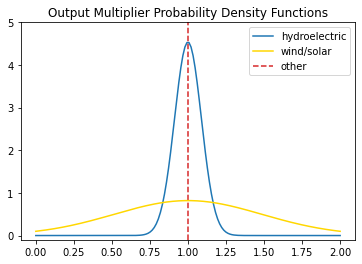

In [246]:
# stats.norm(mu, std)
_month = 'Jan'

params1 = outputs_matrix.at[_month, 'hydroelectric'] # outputs_matrix['hydroelectric'].loc[month][1:-1].split(',')
mu1 = float(params1[0])
std1 = float(params1[1])
pdf1 = norm(mu1, std1)

params2 = outputs_matrix.at[_month, 'distributed solar'] # outputs_matrix['distributed solar'].loc[month][1:-1].split(',')
mu2 = float(params2[0])
std2 = float(params2[1])
pdf2 = norm(mu2, std2)

x = np.linspace(0,2,150)
plt.ylim([-.1,5])

plt.plot(x, pdf1.pdf(x), color='tab:blue')
plt.plot(x, pdf2.pdf(x), color='gold')
plt.axvline(x = 1, color = 'tab:red', ls='--', zorder=-1)

plt.legend(['hydroelectric', 'wind/solar','other',])
plt.title('Output Multiplier Probability Density Functions')

plt.show()

Now we need to take this and output a config file or series of config files to be instantiated on emulab

In [247]:
def GenOutputCoefficient(mu, sigma, size:int=12,seed=32000):
    """takes parameters from a normal dist.
    returns a list of coefficients.
    """
#     print(mu, sigma)
    if (np.isnan(mu)):
        return [1] * size
    else:
        output = np.random.default_rng(seed).normal(mu, sigma, size)
        output = [v if v > 0 else 0.0 for v in output] # remove all negative values
    return output

In [248]:
print(outputs_matrix.columns.values)
for month in outputs_matrix.index:
    print(month, end=' ')
    for col in outputs_matrix:
        mu = outputs_matrix.at[month, col][0]
        sigma = outputs_matrix.at[month, col][1]
        outputs = GenOutputCoefficient(mu, sigma, size = 1, seed=3000)
        print('{:.3f}'.format(outputs[0]), end=' ')
    print()

['hydroelectric' 'utility-scale solar' 'natural gas-fired'
 'land-based wind' 'nuclear' 'petroleum-fired' 'distributed solar'
 'offshore wind']
Jan 1.039 1.214 1.000 1.214 1.000 1.000 1.214 1.214 
Feb 1.041 1.213 1.000 1.213 1.000 1.000 1.213 1.213 
Mar 1.034 1.222 1.000 1.222 1.000 1.000 1.222 1.222 
Apr 1.035 1.214 1.000 1.214 1.000 1.000 1.214 1.214 
May 1.038 1.198 1.000 1.198 1.000 1.000 1.198 1.198 
Jun 1.041 1.196 1.000 1.196 1.000 1.000 1.196 1.196 
Jul 1.050 1.179 1.000 1.179 1.000 1.000 1.179 1.179 
Aug 1.053 1.171 1.000 1.171 1.000 1.000 1.171 1.171 
Sep 1.056 1.183 1.000 1.183 1.000 1.000 1.183 1.183 
Oct 1.049 1.198 1.000 1.198 1.000 1.000 1.198 1.198 
Nov 1.036 1.211 1.000 1.211 1.000 1.000 1.211 1.211 
Dec 1.038 1.197 1.000 1.197 1.000 1.000 1.197 1.197 


## Take these functions and put it in the generator.
Have them update their state on a timer

In [249]:
def FormatGenConfigFiles(frame, num_hosts=1):
    """Takes two arguments a dataframe of the number of facilities
    and the number of config files you'd like to generate (one for each host).
    """
    columns = ['counts','capacity_mw','total_output']
    df = frame[columns] # make a copy
    # to load balance the trackers we should allocate a roughly even total_output to each tracker
    sorted_df = df.sort_values('capacity_mw', ascending=False)
#     print(sorted_df)
    
    capacity_per_host = df['total_output'].sum() / num_hosts
    print()
    print("Config files will include:")
    print("    - {} generators sharded across {} hosts".format(df['counts'].sum(), num_hosts))
    print("    - Each host will be responsible for ~{:.2f} MW".format(capacity_per_host))
    print("    - For a total of {} MW of generation capacity".format(df['total_output'].sum()))    
    print()
    
    facil_remaining = sorted_df.copy()
    print("\nGeneration to allocate")
    print("---------")
    print(facil_remaining)
    print("---------")
#     print(pd.DataFrame(facil_remaining.sum(),columns=['Total']).set_index('Total',inplace=True).T)
#     print("---------")

    # copy df and reset mutable values to zero 
    initial_df = sorted_df.copy()
    initial_df['counts'] = 0
    initial_df['total_output'] = 0
    
    # create a list containing a dataframe for each host.
    host_responsibilities = [initial_df.copy() for i in range(num_hosts)]
    
    # iterate through the kinds of facilities,
    # starting with the ones with the highest output
    print()
    for kind in facil_remaining.index:
#         print("There were {} {} generators, ".format(facil_remaining.at[kind,"counts"], kind), end='')
        while (facil_remaining.at[kind,"counts"] > 0):
            for i in range(num_hosts):
                host_responsibilities[i].at[kind,"counts"] += 1
#                 print(host_responsibilities[i].at[kind,"counts"], end=" ")
#                 print(facil_remaining.at[kind,"counts"])
                facil_remaining.at[kind,"counts"] -= 1
                if (facil_remaining.at[kind,"counts"] == 0): break
#         print("now there are {} {} generators".format(facil_remaining.at[kind,"counts"], kind))

    for i, host in enumerate(host_responsibilities):
        host_responsibilities[i]['total_output'] = host_responsibilities[i]['counts'] * host_responsibilities[i]['capacity_mw']
        print("\nHost {}".format(i+1))
        print("---------")
        print(host)
    
    return host_responsibilities
    
host_configs = FormatGenConfigFiles(gen_to_instantiate, num_hosts=1)
host_configs

host_facils = 0
host_output = 0

print("---------")
print("\nHost allocation summary")
print("---------")
for i, h in enumerate(host_configs):
    host_facils += h.counts.sum()
    host_output += h.total_output.sum()
    print("Host {}:".format(i+1))
    print("    - Facilities {}".format(h.counts.sum()))
    print("    - Capacity   {} MW".format(h.total_output.sum()))
print("=========")
print("Simulation total:")
print("    - Facilities {}".format(host_facils))
print("    - Capacity   {} MW".format(host_output))
print("---------")

# print()
# print("resulting facilities: {}".format(host_facils))
# print("resulting output:     {} MW".format(host_output))


Config files will include:
    - 5 generators sharded across 1 hosts
    - Each host will be responsible for ~490.00 MW
    - For a total of 490.0 MW of generation capacity


Generation to allocate
---------
                     counts  capacity_mw  total_output
type                                                  
nuclear                   0    975.00000           0.0
petroleum-fired           0    259.20000           0.0
hydroelectric             1    140.00000         140.0
natural gas-fired         3     98.00000         294.0
land-based wind           0     57.00000           0.0
offshore wind             0     57.00000           0.0
utility-scale solar       1     56.00000          56.0
distributed solar         0      0.00625           0.0
---------


Host 1
---------
                     counts  capacity_mw  total_output
type                                                  
nuclear                   0    975.00000           0.0
petroleum-fired           0    259.20000       

Next we need to take this and generate a config file...
***
### Writing Config Files
Let's write each dataframe to a CSV and try loading it from a standalone program.

In [250]:
for i, h in enumerate(host_configs):
    path = 'sim/2030/generators/config/host_config_{}.csv'.format(i+1)
    h.to_csv(path)

### Loading from config & adding address
When the generator bootstraps it will need to provide its **IP address** and the **port** it would like to be contacted at.

We'll load the `generator`s from config folder.

In [251]:
import os

config_path = 'sim/2030/generators/config/'
config_files = [f for f in os.listdir(config_path) if os.path.isfile(os.path.join(config_path, f))]
config_files

['output_config.csv', 'host_config_1.csv', 'portions.csv']

In [252]:
# config_from_disk = []
# for file in config_files:
#     full_path = os.path.join(config_path, file)
#     print(pd.read_csv(os.path.join(config_path, file)).set_index('type'))

In [253]:
def MakeGenInstances(ref_df, starting_port=33000, latency_best_case=10, latency_worst_case=100, hosts='localhost'):
    """takes a data frame of counts and capacities,
    returns a dataframe with IP addresses and ports.
    
    Latency is in ms
    """
#     # this let's you determine your own IP
#     import socket
#     ip_addr = socket.gethostbyname(socket.gethostname())
    
    num_rows = ref_df['counts'].sum()
    
    # intialize a empty dataframe
    _df = pd.DataFrame()
    gen_types = []
    gen_capacity = []
    for kind in ref_df.index:
        for i in range(int(ref_df.at[kind, 'counts'])):
            gen_types.append(kind)
            gen_capacity.append(ref_df.at[kind, 'capacity_mw'])
    _df['type'] = gen_types
    _df['capacity_mw'] = gen_capacity
    
    # assign IP and ports to each generator
    _df['addr'] = ["{}:{}".format(hosts, starting_port+i) for i in range(num_rows)]
    # add a latency from 10 ms to 100 ms (uniformly distributed)
    _df['rtt'] = np.random.randint(latency_best_case, latency_worst_case+1, num_rows)
    
    return _df

In [254]:
config_files = [f for f in config_files if 'host_config' in f]
config_files

['host_config_1.csv']

In [255]:
gen_instance_settings = MakeGenInstances(pd.read_csv(os.path.join(config_path, config_files[0])).set_index('type'),
                 starting_port=33000)
gen_instance_settings

,type,capacity_mw,addr,rtt
0,hydroelectric,140.0,localhost:33000,39
1,natural gas-fired,98.0,localhost:33001,18
2,natural gas-fired,98.0,localhost:33002,83
3,natural gas-fired,98.0,localhost:33003,10
4,utility-scale solar,56.0,localhost:33004,50


__12/6/2022 21:22__

At this point I'm able to generate all the necessary metadata to instantiate all generators on a host

__TODO:__
- move to seperate client program. 
- have that client program launch instances of a generatorRPC clients
- have those instances request hashes

Let's templatize the writing of a bashscript. Then modify the access priviledges of the file.

In [256]:
def AppendLine(s, line):
    """takes a base string, s, and appends line on a newline"""
    return "{}\n{}".format(s,line)

In [267]:
def FrameToGeneratorLaunchScript(_df, background_task=False):
    """takes a data frame of generator data and generates
    rows than can launch a generator client.
    """
    generators = []
    dest_addr = 'localhost:50051'
    
    fg_bg = ""
    if background_task:
        fg_bg = "&"
    
    for i in _df.index:
        line = "python3 generator.py '{}' '{}' {} {} '{}' {}".format(
            _df.at[i,"addr"],
            dest_addr,
            _df.at[i,"rtt"],
            _df.at[i,"capacity_mw"],
            _df.at[i,"type"],
            fg_bg)
        generators.append(line)
    return generators

In [268]:
def FrameToGeneratorKillScript(_df):
    """takes a data frame of generator data and generates
    rows than can launch a generator client.
    """
    generators = []
    dest_addr = 'localhost:50051'
    for i in _df.index:
        # python3 stop_generator.py localhost:33001 
        line = "python3 stop_generator.py '{}' &> /dev/null".format(_df.at[i,"addr"])
        generators.append(line)
    return generators

In [269]:
gen_instance_settings.head()

,type,capacity_mw,addr,rtt
0,hydroelectric,140.0,localhost:33000,39
1,natural gas-fired,98.0,localhost:33001,18
2,natural gas-fired,98.0,localhost:33002,83
3,natural gas-fired,98.0,localhost:33003,10
4,utility-scale solar,56.0,localhost:33004,50


In [270]:
# change it to an executable
subprocess.run(["chmod", "+xu", gen_launcher_path])

CompletedProcess(args=['chmod', '+xu', 'sim/2030/generators/launch_generators.sh'], returncode=0)

In [271]:
import subprocess
# for each generator in the trial
# we'll instantiate one version of the generator client
gen_launcher_path = 'sim/2030/generators/launch_generators.sh'

generator_script = "#!/usr/bin/env bash \n" # this will need to be changed for ubuntu

lines = FrameToGeneratorLaunchScript(gen_instance_settings, background_task=True)
for line in lines:
    generator_script = AppendLine(generator_script, line)

generator_script = AppendLine(generator_script, "\necho ''")
generator_script = AppendLine(generator_script, "echo '{} generators instantiated'".format(len(lines)))

# write the program
with open(gen_launcher_path, 'w') as reader:
    reader.write(generator_script)

# test it
subprocess.run(["cat", gen_launcher_path])

#!/usr/bin/env bash 

python3 generator.py 'localhost:33000' 'localhost:50051' 39 140.0 'hydroelectric' &
python3 generator.py 'localhost:33001' 'localhost:50051' 18 98.0 'natural gas-fired' &
python3 generator.py 'localhost:33002' 'localhost:50051' 83 98.0 'natural gas-fired' &
python3 generator.py 'localhost:33003' 'localhost:50051' 10 98.0 'natural gas-fired' &
python3 generator.py 'localhost:33004' 'localhost:50051' 50 56.0 'utility-scale solar' &

echo ''
echo '5 generators instantiated'

CompletedProcess(args=['cat', 'sim/2030/generators/launch_generators.sh'], returncode=0)

In [272]:
# for each generator in the trial
# kill the previously instantiated generator
gen_launcher_path = 'sim/2030/generators/kill_generators.sh'

generator_script = "#!/usr/bin/env bash \n" # this will need to be changed for ubuntu

lines = FrameToGeneratorKillScript(gen_instance_settings)
for line in lines:
    generator_script = AppendLine(generator_script, line)

generator_script = AppendLine(generator_script, "\necho ''")
generator_script = AppendLine(generator_script, "echo '{} generators terminated'".format(len(lines)))

# write the program
with open(gen_launcher_path, 'w') as reader:
    reader.write(generator_script)

# test it
subprocess.run(["cat", gen_launcher_path])

#!/usr/bin/env bash 

python3 stop_generator.py 'localhost:33000' &> /dev/null
python3 stop_generator.py 'localhost:33001' &> /dev/null
python3 stop_generator.py 'localhost:33002' &> /dev/null
python3 stop_generator.py 'localhost:33003' &> /dev/null
python3 stop_generator.py 'localhost:33004' &> /dev/null

echo ''
echo '5 generators terminated'

CompletedProcess(args=['cat', 'sim/2030/generators/kill_generators.sh'], returncode=0)

In [ ]:
# # test it
# with open('logs/bootstrap_server.log', 'a') as f:
#     subprocess.run(["./{}".format(gen_launcher_path)], stdout=f)

In [ ]:
# import time

# # bootstrap_server_proc = subprocess.Popen(["python","bootstrap_server.py"])
# # time.sleep(15) # ms
# bootstrap_server_proc.terminate()

## Tracker Launcher

Here we will programmatically script the launch of N trackers.

In [ ]:
HASH_SIZE = 32

# copied from above
def assignBucket(hash_result, num_buckets=8):
    # map hash_result in to the range [0,1]
    hash_result += 2**(HASH_SIZE-1)
    p = hash_result / 2**(HASH_SIZE)
    b = int(np.round(p * (num_buckets)))
    if b >= num_buckets: b = 0 
    return b

In [ ]:
def TrackersPerHost(num_trackers=12, num_hosts=1):
    """Try to assign an even number of trackers to each host."""
    trackers_per_host = {i: 0 for i in range(num_hosts)}
    trackers_remaining = num_trackers
    while trackers_remaining > 0:
        for i, tracker in enumerate(range(num_trackers)):
            trackers_per_host[i % num_hosts] += 1
            trackers_remaining -= 1

    return trackers_per_host

NUM_TRACKERS = 2 # 12
NUM_TRACKER_HOSTS = 1

# response is a dict of format { <host_id>: <num_trackers> , ... }
trackers_per_host = GetTrackersToLaunch(NUM_TRACKERS, NUM_TRACKER_HOSTS)
trackers_per_host

In [ ]:
import typing

def GenTrackerLaunchScripts(trackers_per_host: dict, port_start: int = 32000) -> str:
    """Take dict of format { <host_id>: <num_trackers> , ... }
    
    returns str # the script(s) to execute
    """
    scripts = []
    
    total_trackers = 0
#     for host in trackers_per_host:
#         total_trackers += trackers_per_host[host]
#     trackers_scripted = 0
        
    tracker_script_header = "#!/usr/bin/env bash \n" # CHANGE for ubuntu
    
    for host in trackers_per_host:
        script = tracker_script_header # start new script
        script = AppendLine(script, "# python tracker.py PORT HOST_ID NUM_TRACKERS")
        for tracker in range(trackers_per_host[host]):
            line = "python tracker.py {} {} {}".format(port_start+total_trackers, host, NUM_TRACKERS)
            script = AppendLine(script, line)
            script = AppendLine(script, "echo 'tracker launched on port {}'".format(port_start+total_trackers))
            total_trackers += 1
        script = AppendLine(script, "\necho '' && echo '{} trackers instantiated'".format(trackers_per_host[host]))
        scripts.append(script)
        

#     return scripts
    return scripts

tracker_scripts = GenTrackerLaunchScripts(trackers_per_host)
for script in tracker_scripts:
    print(script)

# lines = FrameToGeneratorLaunchScript(gen_instance_settings)
# for line in lines:
#     generator_script = AppendLine(generator_script, line)

# generator_script = AppendLine(generator_script, "\necho ''")
# generator_script = AppendLine(generator_script, )

In [ ]:
def WriteScripts(scripts, path):
    """takes a list of scripts and writes them to disk at the provided path"""
    for i, script in enumerate(scripts):
        file_path = os.path.join(path, 'launch_trackers_{}.sh'.format(i))
        with open(file_path, 'w') as writer:
            writer.write(script)
        
        # change it to an executable
        subprocess.run(["chmod", "+xu", file_path])

tracker_folder = 'sim/2030/trackers'

WriteScripts(tracker_scripts, tracker_folder)

In [ ]:
# python generator.py '10.9.57.21:33000' 'localhost:50051' 61 140.0 'hydroelectric'

***

Next we'll instantiate our consumers at `Consumer` to `Generator`, **20,000:1**.

In [ ]:
num_consumers = round(CTG * num_generators)
print("Generators: {}".format(num_generators))
print("Consumers:  {:,}".format(num_consumers))

In [ ]:
def getConsumers(avg_res_consump, _num_consumers, consumers_types=["Residential"]):
    """returns a dataframe of the instantiation data for the consumers in a given simulation"""
    consumers_to_initialize = pd.DataFrame([[np.round(_num_consumers).astype(int), avg_res_consump]], index=consumers_types, columns=["num_consumers","avg_consump"])
    consumers_to_initialize["total_consump"] = consumers_to_initialize["num_consumers"] * consumers_to_initialize["avg_consump"]
    return consumers_to_initialize

consumers_to_initialize = getConsumers(res_unit_consump, num_consumers)
consumers_to_initialize

In [ ]:
print("Simulation Parameters: ")
print("Consumption: {} MW".format(consumers_to_initialize["total_consump"].loc["Residential"]))
print("Generation:  {} MW".format((gen_to_instantiate["counts"] * gen_to_instantiate["capacity_mw"]).sum()))

***

In [ ]:
# we'll pull a generator at random from this distribution
future_facil_counts = np.round(facil_counts.T * capacity_increase).astype(int).T.counts.values
plt.bar(facil_counts.index, future_facil_counts, color=colors.color[facil_counts.index].values)
plt.title("2030 Generator Counts:\n{} Facilities".format(sum(future_facil_counts)))
plt.ylabel("number of generators")
# plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

## Hashing into uniform buckets

To evently distribute the labor of matching a `Generators` with a set `C` of consumers, we need to generate hashes uniformly and distributed over the range [0,2<sup>n</sup>). In the case of MurmurHash3, that's a 32 bit range.

For reproduceability, the hash should be deterministic, so using a specified seed is important.

In [ ]:
import warnings
warnings.filterwarnings(action='once')

In [ ]:
import mmh3

In [ ]:
print(mmh3.hash('foo', 42))
print(mmh3.hash('bar', 42))
print(mmh3.hash('foo', 42))

In [ ]:
128/8

In [ ]:
a = mmh3.hash('foo', 42)
a.to_bytes(4, "big", signed=True).decode('unicode_escape')

***

# gRPC

We'll be defining the **services** and **types** used by those services.

Let's start by defining the different services each node type will need to support:

## Generators

A `generator` must be able to request being added to the network; declare to the network what its type; genertaion capacity (in MWs) and its safety threshold (% of total capacity), be made aware of its tracker, update its tracker when its capacity has changed; request that the tracker shed a minimum amount of load (by reassigning consumers to other generators); hold the state of  demand on itself (by keeping an associative array of active consumers and their consumption); "black out" if demand from the consumers in its *distribution trees* exceeds its current generation capacity; track the time and duration of blackouts.

Black outs occur when a `tracker` is too slow to reassign excess demand on a `generator`. During a black out all consumers in the `generator`'s distribution tree are **choked**. A such, a `generator` must store its own copy of its distribution tree, so it can multicast to the `consumer`s that they are being choked.

### Services

#### `GeneratorJoin`
##### Methods:
- `GeneratorJoin(PeerCtx)` &rarr; `IdHash`
- `ConsumerJoin(PeerCtx)` &rarr; `Guid`



## Consumers

A `consumer` must be able to request a 128-bit ID<sup>1</sup>; maintain the state of its `tracker` and `generator` addresses, and its `current_consumption` and its `last_consumption_signalled`; mutate its `current_consumption` pseudo-randomly; update its generator after each call to `mutate_consumption`; update its `tracker` if and only if the change in consumption is above a given threshold or if it is `deferrable`. When the `consumer` signals that it wants to start `deferrable` consumption, it starts a timeout. At timeout the deferred consumption is added to its `generator`.

<sup>1</sup> For interchangability with the devices IPv4 address, we'll use 128-bit random int bit shifted 80 + 16 bits to the right, so we are left with a 32-bit address in the least significant digits. In the future, we may just use the real consumers IPv6 address.

## Tracker

A `tracker` must be able to maintain state about the generators assigned to it, the consumers assigned to it (and their `current_consumption`); track the available capacity of all generators managed by a peer tracker; request to pass consumers from their management to a peer tracker with avaiable capacity.

## Bootstrapping Server

The `bootstrap_server` provides IDs to all generators and consumers that request them.

### Services

#### `JoinGridService`
##### Methods:
- `GeneratorJoin(PeerCtx)` &rarr; `IdHash`
- `ConsumerJoin(PeerCtx)` &rarr; `Guid`



## Generator Metronome

the `generator_metronome` server receives a `start` signal once all the peers have been bootstrapped; then it 
multicasts updates to rewnewable generators after each timestep (`t`) has been computed.


***

In [ ]:
# plt.pie(np.round(g30[g30.portion > 0].portion*100,1), labels=g30[g30.portion > 0].index,autopct='%.1f%%')
# plt.title("Electricity generation by source\nNew York State (2030)")
# plt.show()

In [ ]:
# plt.pie(np.round(g22[g22.portion > 0].portion*100,1), labels=g22[g22.portion > 0].index,autopct='%.1f%%')
# plt.title("Electricity generation by source\nNew York State (2022)")
# plt.show()

In [ ]:
hydro_fluctuations = (monthly_elec.hydroelectric.max() - monthly_elec.hydroelectric.min()) / monthly_elec.hydroelectric.max()
print("Hydroelectric generation fluctuates by: {}%".format(round(hydro_fluctuations*100)))

In [ ]:
# Monthly electric generation Hydro
plt.scatter(monthly_elec.index, monthly_elec.hydroelectric)
plt.show()

In [ ]:
other_fluctuations = (monthly_elec.other_renewables.max() - monthly_elec.other_renewables.min()) / monthly_elec.other_renewables.max()
print("Solar and Wind generation fluctuates by: {}%".format(round(other_fluctuations*100)))

In [ ]:
# Monthly electric generation Solar and Wind
plt.scatter(monthly_elec.index, monthly_elec.other_renewables, color="gold")
plt.show()